In [1]:
import sys
sys.path.append("../")

from classify import *

from flask import Flask, request, jsonify

import base64
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

from skimage import measure
from skimage import io
from skimage.transform import resize
from skimage.filters import inverse

from PIL import Image
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.autograd import Variable

In [2]:
#Defining general variables.
Momentum = 0.9
Batch_size = 50
Epochs_number = 5
Learning_rate = 0.001
np.random.seed(3)

#Building the network.
class Neural_Network(nn.Module):
    
    #Definition.
    def __init__(self):
        super(Neural_Network, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.Losses = []
        self.Accuracies = []
     
    #Forward function.    
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        
        return x 
    
    #Training function.
    def train_net(self, Training_set, Epochs_number, Learning_rate, Momentum):
        
        Loss_function = nn.CrossEntropyLoss()
        Optimizer = optim.SGD(net.parameters(), lr = Learning_rate, momentum = Momentum)

        for epoch in range(Epochs_number):

            Current_loss = 0.0
            Current_accuracy = 0.0
            
            for batch_index, training_batch in enumerate(Training_set, 0):
                
                Inputs, Labels = training_batch
                Inputs, Labels = Variable(Inputs), Variable(Labels)

                Optimizer.zero_grad()
                Outputs = self.forward(Inputs)

                Loss = Loss_function(Outputs, Labels)
                Current_loss += Loss.item()
                
                Loss.backward()
                Optimizer.step()
                
                Total_pred = 0
                Correct_pred = 0
                
                for data in training_batch:
                    Images, Labels = training_batch

                    Outputs = self.forward(Variable(Images))
                    Dummy, Pred_labels = torch.max(Outputs.data, 1)
                    
                    Correct_pred += (Pred_labels == Labels).sum().item()
                    Total_pred += Pred_labels.size(0)
                    
                Current_accuracy += (100 * Correct_pred)/Total_pred

                if batch_index % 300 == 299:
                    
                    print('[Epoch: %d Batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, Current_loss/300)) 
                    
                    self.Losses.append(Current_loss/300)
                    self.Accuracies.append(Current_accuracy/300)

                    Current_loss = 0.0
                    Current_accuracy = 0.0
      
        print('Training finished')

In [84]:
class ClassifyImage(object):
    output_size = 28
    color = list(mcolors.BASE_COLORS.values())
    
        
    def __init__(self):
        self.crop_list = []
        self.cropped_images = []
        
    def set_img(self, img):
        self.img = img #[:, :, 0]
    
    def show_original_img(self):
        plt.imshow(self.img, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
        
    def get_shape(self):
        return self.img.shape
        
    def crop_image(self, img, y_min, height, x_min, width):
        y_min = int(y_min)
        height = int(height)
        x_min = int(x_min)
        width = int(width)

        return img[y_min:y_min+height , x_min:x_min+width,]
    
    
    def find_img_contours(self, show_output = False):
        self.countours = measure.find_contours(self.img, 1, fully_connected="high", positive_orientation="high")
        
        self.crop_list = []
        
        for n, contour in enumerate(self.countours):

            # Get extreme values of the contours
            self.y_min, self.x_min = np.min([contour], axis=1)[0]
            self.y_max, self.x_max = np.max([contour], axis=1)[0]

            # Compute the width and height a the box surrounding the countrous
            self.width = self.x_max - self.x_min
            self.height = self.y_max - self.y_min
            
            if(show_output):
                plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
                plt.imshow(self.img, cmap=plt.cm.gray_r, interpolation='nearest')

                plt.axvline(x=self.x_min, color=self.color[n], linestyle='--')
                plt.axvline(x=self.x_min + self.width, color=self.color[n], linestyle='--')
                plt.axhline(y=self.y_min + self.height, color=self.color[n], linestyle='--')
                plt.axhline(y=self.y_min, color=self.color[n], linestyle='--')

            self.crop_list.append({'y_min': self.y_min, 'height': self.height, 'x_min': self.x_min, 'width': self.width, 'y_max': self.y_max, 'x_max': self.x_max})
    
        # Sort the array in logical order
        self.crop_list = sorted(self.crop_list, key=lambda x: x['x_min']) 
        
        self.to_be_deleted = []
        for crop in self.crop_list: 
            for crop_compare in self.crop_list:
                x_min_within_x_axis = bool(crop['x_min'] > crop_compare['x_min'] and crop['x_min'] < crop_compare['x_max'])
                x_max_within_x_axis = bool(crop['x_max'] < crop_compare['x_max'] and crop['x_max'] > crop_compare['x_min'])
                
                y_min_within_y_axis = bool(crop['y_min'] > crop_compare['y_min'] and crop['y_min'] < crop_compare['y_max'])
                y_max_within_x_axis = bool(crop['y_max'] < crop_compare['y_max'] and crop['y_max'] > crop_compare['y_min'])
                
                if(x_min_within_x_axis and x_max_within_x_axis and y_min_within_y_axis and y_max_within_x_axis):
                    self.to_be_deleted.append(crop)
               
        # Delete al the items form the to be deleted list
        self.crop_list = [x for x in self.crop_list if x not in self.to_be_deleted]    
        
        print('Number of contours found: {0}'.format(len(self.countours)))
        print('Number of contours deleted: {0}'.format(len(self.to_be_deleted)))
        print('Number in final crop list: {0}'.format(len(self.crop_list)))
        
        if(show_output):
            plt.show()
        
        
    def apply_cropping(self, show_output = False):
        # Get size of the original image
        original_size_y, original_size_x = self.get_shape()
        self.count_dropped = 0

        self.find_img_contours(show_output)
        
        for crop in self.crop_list:    
            
            self.precentage = (crop['height']*crop['width'])/(original_size_y*original_size_x)
            
            # Crop image
            self.cropped_image = self.crop_image(self.img, crop['y_min'], crop['height'], crop['x_min'], crop['width'])
            
            if(show_output):
                # Plot cropped image
                plt.imshow(self.cropped_image,cmap=plt.cm.gray_r, interpolation='nearest')
                plt.title('Cropped number')
                plt.show()

            # Prepend and append white vertical white lines on each side to make it a square
            if(crop['height'] > crop['width']):
                ny,nx = self.cropped_image.shape

                # Divide the differences between height and width by 2 since there are two lines added each iteration
                for x in range(0, int((crop['height']-crop['width'])/2)):

                    # Add two lines, one on each side
                    self.cropped_image = np.c_[np.zeros(int(ny)), self.cropped_image, np.zeros(int(ny))]

            # Prepend and append white horizontal white lines on each side to make it a square
            if(crop['width'] > crop['height']):
                ny,nx = self.cropped_image.shape

                # Divide the differences between height and width by 2 since there are two lines added each iteration
                for x in range(0, int((crop['width']-crop['height'])/2)):
                    # Add two lines, one on each side
                    self.cropped_image = np.append(np.zeros([1, int(nx)]), self.cropped_image, axis=0)
                    self.cropped_image = np.append(self.cropped_image, np.zeros([1, int(nx)]), axis=0)
    
            if(show_output):
                # Plot cropped squared image
                plt.imshow(self.cropped_image,cmap=plt.cm.gray_r, interpolation='nearest')
                plt.title('Make corpped image a square')
                plt.show()

            
            self.cropped_images.append(self.cropped_image)
            # Classify resized image
            #cropped_resized_reshaped = np.array(cropped_image_resized).flatten().reshape(1, -1)
            #print('Number classified: {0}'.format(classifier.predict(cropped_resized_reshaped)[0]))


        print('{0} contours dropped'.format(self.count_dropped))
        
        
    def classify(self):
        print(len(self.cropped_images))
        
        self.apply_cropping(show_output=True)
        
        net = Neural_Network()
        net.load_state_dict(torch.load('../tensor_sd.pt'))
        net.eval()
        
        for image in self.cropped_images:
            image = Image.fromarray(image)
            
            transfrom = transforms.Compose([
                transforms.Grayscale(),
                transforms.Resize(self.output_size - 10),
                transforms.CenterCrop(self.output_size),
                transforms.ToTensor(),
            ])

            img_tensor = transfrom(image)
            
            plt.imshow(np.array(img_tensor)[0, :, :],cmap=plt.cm.gray_r, interpolation='nearest')
            plt.title('Image used for classification')
            plt.show()
            
            img_tensor.unsqueeze_(0)        
            Outputs = net.forward(Variable(img_tensor))
            Dummy, Predicted_labels = torch.max(Outputs.data, 1)
    
            print('Classified: {0}'.format(Predicted_labels.numpy().max()))

## Copy image output from online and paste here

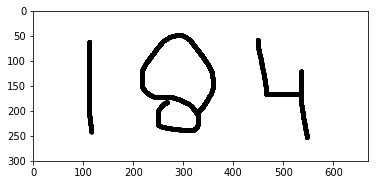

In [85]:
image_base = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAp4AAAEsCAYAAABqnLNwAAAAAXNSR0IArs4c6QAAKVlJREFUeAHt3U/sLdddGPBAsNOmCgKpStxNl1SqREgpCycSgmbTSlTqpkipsngkSrrtAqliyQq1uDGNTUGIDVUVqjZNgtSmiyrh9xwHJ4gWhECC8C91ojapnbpOcBIb/6Hnm7zxu75v5s733Pk/8znSeffemTPnz+ecM29+c2fmvu51AgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEqgXeU1E+X+JclvnLnNd7PEaO8L5T4gRK/s0SBAAECBAgQIEBgZwIPlvZ8ucQ5Di5rynjrzpw1hwABAgQIECBwSIG1HmyeH5jelN75rkP2kEYTIECAAIENCzxQ6v5HJX6zxLm+Qo1yvlhifHV6f4nCcgLx1fV7SvxsiecHd2v//LVS5+8oUSBAgAABAvcIxAHGwyU+U+L5f2hxIBLXjz1U4htKFKYXuFWKOO+HJT7HAa/r9qbv77YS4qDtV0tcot/HLNPBZ1vvTrfsvpL1O0uM/fnn7sR4H8tinUCAAIHZBYbciPBkqa0DkXG7bImzmrUHFv7DGrfPM7m9qySq7ae1pnfwmenx4WnC+cMXxk2s0xfDneVAgEBCYMxrwx5NlCdJv8CtkmStBwpt9fpoqa/r9vr7dawUT2xsfLSNmdNl/ngZa2R05/PuxJiJNAIBAgRGEYivy2+X+KUSp7we8LmSv1An8KaS/P0l/laJp/8Zb/H9z5Q2OAAtCBOHb5T8tzg+uur8YmmPs23TDprPJ8ZMpBEIECAwSCAOAj5SYtcOf4rlgyp8kI3jDM/HS/xfJU7RB0vm+dXSJgcRBWHCsLcDz2a8ulRnukGTOeEQaQQCBAhUC8R1gXHBeLMzn/u1usIH2WDpfpl7HDj4nG5g7+2r9mZsfmU6ssPn3Bj3vR4eCgABAjmBuE4zvkbv26nMsT5X42OkWlO/zNH352U4+JxmnL/ryrkeD5WPMTl1+P5SwPlYyH5+ZOrKHTT/rP9BeTSbAIGMQHyNHl/XZncoc6XL1H3vaX5qhf0yV/+flvP03jt6ofbFAf2HkmNsroPNc4qo4+lYqHnvOuFzzeGfs/7DS5IDAQK7EJjr5qDszulSul2AX9mIt5XtLtkccd2nrrS02WWBuB7yfSX+ZonNNZ8vl/cxxuKAPx6NtnS49uAznpIgjCuQ3feMW6rcCBDYlED8x/KeEn+7xOxOYw3pNoU8UmXjDM3Nwv10a6S2nGcTBw9xw9CQsRVfvQrHFLj24NNZz3HHS3b+jluq3AgQ2IxA7KyzX6VldyhzpdsM8kgVjb6KnwCcyzfKibtP45eD4iczHyhx6hAHAfGopCFtdPA5dS+tN/+YI/HIpJrx84n1NmeTNcvab7JxKk2AwHCBa28eyO5cMunOrw3LbBNpjhb+Z2lw1mZoulsL48YB6JDHc8Xd2HEQIhxPIB4hVjv+j6c0XYuz9tPVQM4ECKxaYO7HpWSuDbPjunfI/FhZlHW5Jl1cu/d7Jb7l3qIXXXLNQUTT/scWrbnClxSoHTe3lqzszspu5l/f686arTkECGQFmpsF+nYS167/tVKR2muosmVl27iHdP+9NCLrkk0Xef7TEt+0cqA4c5lt03m6D668bao3nUDcOHQ+Hi59nq4mx8r5kvHpumOpaC0BAq8KTHHg+WzJPR6/VHvA2VTqdOd06X2T/givlxyy64b2y5LOQw4+rx2HS7ZX2cMFot+zcyPSvXl4kXKoMIdFgMBBBcb8qj1+xWiMG1Cy/1kcqcuyJm3pxuqXpb2vfYTUp5euuPIXE/jjUnLbnGhbFmmF4QJttm3LhpckBwIENikw5Oaip0qLH5yg1W07qbZlExS92ix/p9SszaBt2XMl7RT9sgacuG6zrc19y964hsqrw+wCcRazb2ycrnd2fHgXnXpeej+8JDkQILBJgfgKM/s4pXi0Tvxc5u0S7y9xqnBpZ3W6bqry15jvPy6VOm171/sjPEro15MWp0YvlG1irAvHEzgdB33v47pQYZhAn3GzflgptiZAYNMC8QD595b4mRKbaz7nOshsg2t2TH2vbdvuedlPl8Z1mTxT1h3pwCrGapdF1/KHyjbC8QRulSZ3jYm25c56DhsjbaZty4aVYmsCBAiMKNC2k2pbNmKRm8nqH5Sa/vsSv15iPEz+35b490s84n+Wtdd8xllP4ZgCbfuPrmWuCR42Rrpcz5cPK8XWBAgQGFHgfAfV9XnEImW1UYHHS727xkfb8ni+o3A8gfh1orbx0LXsiH/IjTUqukzPl49VnnwIECAwWOB8B9X1eXBBMti8QBwgdI2PtuU3m2+xBlwjYJxco3bdNm3zrm3ZdbnbigABAhMItO2k2pZNULQsNyjwSKlz2/hoW/b8BtunyuMI1PwE65+PU+Qhc2mbd23LDomj0QRC4Eg3ZGylx2MnlQn6LqN0jDRxM1x2PGTTHUPuOK2Ms54vVjT39SVtjCuhTsD+u85L6gMKxB3dAgEC2xZ4bNvVV/sZBF4qZXy6opy/XZFWUgIECBDYsEDb1zJtyzbcRFUfWSBuGmobI23LRi5adhsSqLnW8/0bateaqto259qWranO6kJgVgFnPGflVhiBSQRqvkKdpAIy3YRAnPXMhr3++le2/dIRIDCRgAPPiWBlS4AAgQ0LvH3DdVd1AgRWLOBGg/V1Tnwtkwn6LqN0nDTGzXH6ekhLs+MkyrCPqZfO+rKtt7XFTgSc8dxJR2oGAQIEEgJ/kEgjCQECBCYTcOA5Ga2MCRAgsDqBz6yuRipEgMChBBx4Hqq7NZYAgYMLfPbg7dd8AgQWFnDguXAHKJ4AAQIzCtSc8XRn+4wdoygCRxFwgfP6etrF6evrky3UyLjZQi8tX8c42fByshpPl3RvTqaV7NsC5qGRQKBHwIFnD9ACq+24FkDfeJE1P4dozm+8s0eofnYfE0UZL3XgWVuuda5S70jAV+076kxNOazAfzhsyzX8GoE4k5kND2QTSkeAAAEC2xSIv5gzcZutU+uxBWp+BjF7NmbsOspvXQJx7WZmHxNpHl5X1Vdfm6zr6huiggQIHEfAjus4fT1GSz9RMsmOmefGKFAeuxDIjplIJ+QFsq75HKUkQIDAxAJ2XBMD7yz77HiJdDc7a7vmXC9QM26uL+V4W2ZdjyejxQQIrFbAjmu1XbO6it0qNcqOl0h33+paoEJLCcRX6Nmxs1Qdt1gu0y32mjoTOLiAHdfBB0BF87NjJdL9WkW+ku5fIG4ayo6f/WuM10Km41nKaacCHumwvo6NHVcm6LuM0n7TxPMV/09F8+Js50sV6SXdv4B9zfh9zHR8UznuTMDjlHbWoZpzGIHfqGjpn5S0DjorwCQlQIAAgWkEnDWbxnVIrv5iHqJ3jG1rHhgfIm8p8alj0GhlhYB9TQVWMinTJJRkxxVwxvO4fa/l2xWofWC8g87t9rWaEyBAgACBSQXiL+ZMnLQSMl+tQO0D42+ttiUqtrRAZj8TaYS8ANO8lZQECKxEwI5rJR2x0mrUPDDeQcNKO3El1bKvGb8jmL7WNG5qfGeJ8fiuz92J8T6WebxbQRAIrEHAjmsNvbDeOmTHR6SLg1SBQJdAdix1bW/5vQJM75rEPSQfLrHLJNa5z+Sul3cEFhPomqTnyxeroIIXE7hVSj4fB5c+x9fyAoEugUtj53Rd1/aW3ytw6nbp/b1b7m/Ju0uTLhnEukgjECCwsEDfRG3WL1xNxS8g0PR95vWjC9RPkdsSyIyjSCPkBZjetfp8edvnEWmEgwk4zb2+Do+Jmgn6LqO0nzQeGL+fvlxLS+xrxu8JpndNXylv+/6fCi9P17lrdoh3OvwQ3ayROxD4HxVt8MD4CixJCRCYRKDvoDMKzaSZpHIyXU5Apy9n31Wyv5i7ZI67/HtK0/9fRfM9ML4C68BJ7WvG73ymd01Z3LXw7kTAgecJxkremqwr6YgVVeOrpS7fXVEf87oC68BJ7WvG73ymd01Z3LXw7kTAV+0nGN4SWKHA3yl1qjno/IkVtkGVCBAgQIDAtwScGVnfQPBX4vr6ZMkaZcdDU0dzupHwekkgxknc/JEJxlRG6dtpsvP1CKYs8uPmUCmd8TxUd2vsxgTeV1nff1eZXvLjCjx13KZrOQECBAicCsRfiZl4uo33+xOIMyKZcXCa5ghnUfbX0/O36FOVY2v+Gm63xNP5eOn9dluYr/ml9p+uy+coJQECkwicTshL7ycpXKarEfhsqcml/j9f9/7V1FxF1izw1spxFeNMyAucz8uuz/kct5uyq+3ny7fbQjW/SsAZkqvYJt0oJmUm6LuM0jbT/M1S7Scrq248VIIdNHl2/9LwfKO8+WvNB6+9AlnfI8xXFr3D5ZgJXON5zH7X6nUL1B50/uC6m6N2KxH4pSvq8QtXbGMTAgQIENiQQPyVmIkbapKqVgj8s2T/N2MknvEpEOgTeFtJ0IyZ7OuzZZsjnJnrs6tZn7WtyXOraVlstefU+3ACJuvhuvzVBv/V8i7b/026+FUjgUCXwHeVFTclNuOl5vX+rkwt7xTI+nZmsKMVLHbUmWM2JXZKAgEC6xCo/Yr9v5Zqx1kpgUCbQJytfKbEN7Wt7FkWl2HFgYNAgAABAjsX8Ffizju4o3l/ryzP9n2TriMriwm87r4rxlMzruJreeE6gcaw7/W63Le1VZ9Bs35brVJbAjsUaCZj3+sOm37oJvX19/n6Hz20lsZfEogznS+WeD5mMp//9FLG1vUKZIwjzRECiyP0sjbuQsBk3UU3VjXiV0rqbL9HOr86U8V7qMRDznTG2HL51bDhkp3Hw0rZxtYsttFPakkgfQCCah8C8R99dgfdpIubkAQC5wK/WBY0Y+Sa1w+eZ+hztUDWvTrjDW7AYoOdpsrHFDBZj9Xvj5fmZvs80sXjlgQCpwL/qHyoGUNtaR87zdD7qwXabNuWXV3AhjZsa3fbsg01SVUJ7FOgbWK2Ldtn64/VqmvOdh5LSGsvCbylrGzbN9Que6LkE9eFCsMFsvbDS1p/DizW30dqSOBbAibrcQbCR0pTs/0d6eKnNAUCIfCfSqwZO11pvx/nqAJdzufLRy10pZmdt7nr80qrr1oEjiPQNTnPlx9HZJ8trT3b+Yf7ZNCqSoE4UDzfF1z72VnOSvxE8mxfJLLafBIWm+9CDTiKgMl6jJ6uPdvpbuNjjIuuVkb//0mJ2f3DpXTxqCUHnV3Sw5Zfcj9d98CwYjax9Wl7L73fRGNUksCeBS5N0NN1ezbYe9tqz3bGDUjCsQTeUZr7dIkx51+583o6/4e8j0cuCdMIZPvl4WmKX1WuWYtVVVplCBxRwGTdf69/tDQx28+RztnO/Y+JaGH088dLrBkbNWm/WvJ2prMgTBhq+mPCaqwi66zFKiqrEgSOLGCy7rv37y/Ny/ZxpIuDVGFdAm8o1XmoxDgjOfbZyJqxUZM2ntHpD5iCMHGo6ZOJq7J49lmLxSuqAgSOLPCdpfEm675HwDcr+jjGgoOFdY2HmKNPVvZhdk7Pke5Lpe4Prot0V7WJr9Cz/birhrc0hkMLikUE1ibwfaVCJuvaemW8+jxS0b8xDpztHM9+rJx+vrIPs/N5iXRfLm1xEDrWyPh2PnHTULYvxy15fblxWF+fqBGBewT+SVlist7DsosFceYy27dNOmc719f1z1/Rj01/rv315Ttti0sI4uYm4TqBbD/HQeqeQ9Zhzwba1iIQXxsJ6xH4u+upipqMLPAfK/P7WEn/UuU2kk8vENd37jU0/x/89dLA3ygxDhx+qkR/ABWECcI/nyBPWRJYvYA7HNfVRTelOj+arJK+S0KtIFn8xx3PTqwJ8cgbB541YvOkjYOxo4UXSoO/t8S4PlnoF6gZI3vej2cd9mzQP1oOmKL5C/eATV9lk53xXGW3DK7Uf6vM4dGS3kFnJZrkkwnEWd7nSnSAMBmxjAkQILCMQPyFmIlfW6Z6Sr1SoOZO9riGUFivwJ6v8czsezx8vn9s1tzZ/vb+7DabIjOeIo1AgMCCAtmJerNgHRVdJxA3EGT7NdLFcz6F9QrE2eia/txj2niG6Z6vdR06+mrm/FNDC5tx+9g33S4xHsk15vNrS3YCAQJLCWT/k/pXS1VQudUCNWc/4oYiYd0CcXnSkyVm5+pe04WBS7W6x2pNv3fnMv+aqQ4u+zz+ojT1d0t8b4nG1fz9rsQDC/RNzmZ9PHZJ2IZA02eZV3cPb6NP42zfmL9cFGeP4izS7RLjP/6hIc641fzBkxmbbWni7K/QLhBnMtvM2pa15zDt0hhnMUaeKbGtTksu+1Cpk+uJC4JAYA6B7GT/vjkqo4zBAm8rOWT7NNIJBKYQeLBkGg+LrxmLmbRxw5HQLhDmGcM55n0cZH6gxC+WOOZX5Nn2XZPuXaWuAgECMwhkJ6ivImbojIFFxF/s2f6MdHH2QSAwtUA8GD4eEB9jrnlgfM04PU87dX23nP+5VdfnKdoYB5u3S4wz6V3lrnn5E6XeAgECMwhkdwQzVEURAwTiD4NsXzbp4utRgcBSAnF39TVnw+InRIV2gWZu972O8aSA2OfEWc0vlHhNP/bVce7132gntZQAgbEFspN77HLlN67AV0p22b6MdM+PW7zcCFwlEAdANeO2STvGgdNVFV75Ro1P3+vNwHa89cp+66vXkusdeA4cFDYnkBXITvRsftLNL/BIKTLbj026D85fTSUSaBWIS0TixwuasZl5vWnNycKMXaSpuVZ27EslsnWcO52v2s0fAjMJZCf3TNVRTKVA3JWe7cPTdJXFSE5gUoG4PvB0fPa9d8a+vTvigLLPrll/mkP4b+1moKYdY726ueh0RHhPYEKB7KSdsAqyHiDwybJttg+bdD8woDybEphKIA58mjGaefV1+709cVNhOOYNX5n+WnOaDxU3j1O6dzxZQmASgezOYJLCZTpYINt/TbpPDS5RBgSmEYj/+F8osRmrfa8301Rj07lee81sn/Ua1j9beuaxEuPsbFeoqacHyHcpWk5gYoHsRJ24GrK/QuDBsk22/yJdnOEQCKxZ4I2lctkxXXOd4prbPHbdsn5rTJc5uLzklW3TpTysI0BgYgETdWLgCbOvvZPdV0kTdoasRxOI6zftl67nzNotnS5+wSieJXzpDGatQrZNtflKT4DAiAIm6oiYM2ZVe1OR6+Fm7BxFDRK4KVvbL11PmLWbK1084zN+wSiu4R3zILNNKNumtm0tI0BgJgETdSbokYt5vOSX7bs4MyoQ2IpAzXWKW2nTnPX8eiksu2+YKl38etHtEqc+0CxFvCZk2/OajXwgQGBeARN1Xu8xSqs92xnXggoEtiRgv3R9bz1UNs36jZ0uHiy/ZMi2xzdAS/aSsg8vkJ2oh4daEUDN2c7oX4HA1gTsl67vsbiWe66fsIxy4icz42v0+AnNpUN23NwsXVHlEziyQHaiHtloTW2vPdsZz/kUCGxNwH5pWI/9Qtk8a5hJ9/Kd/OLJGPFLRmsNmbZEmriBTSBAYCGB7ERdqHqKPRP40/I522eRLg5UBQJbE8iO8a21a676xtnHJ0vMOp6mm/NmoLE9rv3lprHrIT8CBC4InO5wLr2/kIVVMwnE9VOX+uh8XXwlLxDYosD5WO76vMW2zVXnN5SC4nrPOEvZ9tV7s2ztZzFrvG5K4q6xcr68Jl9pNy7gWYLr6sCYjJmg3zJK06bJ9lVTi7iA/qXmg1cCGxLIjnX7pQ116gxVjX1e/CJRJhg7GaWdpFnDBcg7oRzcjNcPzkEGcwn8UmVBny7pHXRWoklOgMCmBV7cdO1VnsABBH6otPH864euzwfgWG0Ta28oij50bedqu1PFEgJd+6Hz5YmsJDmYwPkY6frsjOeBBoYznuvp7B9ZT1XU5ILAFy6sa1v1y2Whs51tMpYRIEDg2wI/C4IAgfkF/nMpsuuvwfPl89dOiSHw4yWe90XfZ3IEti7QN8ab9Vtvp/qPL9CMjb7XF8YvWo4ECPQJ/HlJ0Dc5m/V9eVk/vsCbK/qn6aelfzlkfAU5HlGgGc99r0e00ebLAn1j5nT95ZysJUBgdIHTCXjpfRygCvMLXOqTtnXxjE+BwB4E2sZ327I9tFUbxhWo+a1613mOa7/a3Fzjudqu6azY7c41Vkwl8G+uyPhvXbGNTQisTeDW2iqkPpsSiF9tygbXeWalpCMwkkDbGYS2ZT85UnmyyQncX5K19cOlZY/mspaKwOoFLo3z83Wrb4wKzi4QZzHPx0nX5zg7KhAgMKNA12Q8Xx6PXRLmE/hmKeq8D/o+z1c7JRGYTuBvlKz7xnqz3pMbpuuHrefcjJHMq6/bt97b6r8pgcykjDQeND9ftz5Sisr2S5MubkISCOxBIB4A3ozrvtfP7aHB2jCJQM11nvGzogIBAjMJ9O3Ym/UzVefwxVzzoPgfP7wagL0I/MvSkGafk3l9y14arh2jC8TBZGYMRRpft4/OL0MC3QLZidmdgzVjCjxeMsv2SaT732MWLi8CCws8X8qvGf8LV1fxKxaouc4zxpxAgMBMAtmd/EzVOXQx15zt9LOYhx4yu2r8A6U12f1RpLu1q9ZrzBQCNV+3T1G+PAkQaBHI7uhbNrVoZIHas51xLahAYC8CD5eGZPdHkU4g0CdQ83V7X17WEyAwkkB2Rz9ScbLpEKg92xlfSQoE9iSQ3RdFup/ZU8O1ZTKBmq/bPV98sm6QMYHXCmR39q/dyqexBWrPdsZzPgUCexLI7osinUAgK5AdV56DnBWVjsBAgeykHFiMzS8I1J7t/PSFvKwisEWBW6XS2X3Rz22xgeq8mEB2XPkWabEuUvDRBLKT8mguc7a39mynG4rm7B1lzSGQ3Q9FurgJSSCQFagZW9k8pSNAYIBAdlIOKMKmFwRqz3bGQapAYE8C8SzO7H7o5T01XFtmEciOrUh33yw1UgiBgwtkJ+XBmSZrvrOdk9HKeCMC8etD2f3QH26kTaq5HoH4Cj07vm7WU201IbBfgeyE3K/Aci1ztnM5eyWvRyB+bz27H/LTsOvpt63U5OcrxpfrPLfSq+q5aYHsDn/TjVxp5eMmoax/pHNt50o7UrWuFohH2NTMgasLsuFhBWKMvVJidpwdFkrDCcwlYDLOJf3acuJaoqx9pHNt52v9fNqHwFdKM7Lz4NY+mqwVCwg8VjHOFqieIgkcSyC70z+WyvStvSlFZO0jnbOd0/eJEuYViF/eqpkD89ZOaXsSqPlDf0/t1hYCqxTI7vhXWfkNV+q5UvesvbOdG+5oVW8VqL2+OeaKQGCIQHZ/O6QM2xIgkBAwGRNIEyTJukc6Zzsn6ABZLirwkVJ6zRz4+qK1VfgeBLLjbQ9t1QYCqxYwGefvnjeWIrPuznbO3z9KnFbgmrOdD01bJbkfQCC7zz0AhSYSWFbAZJzX/ztKcS+UmHV3tnPe/lHa9AKfrBj/MU+eLTHmjUBgiEB2nzukDNsSIJAQMBkTSCMmiTM3WfNIJxDYm0DN+I+09+8NQHsWEciOu0Uqp1ACRxIwGeft7ZqznXEDkkBgTwIPlsZk9zmRzk8Y7qn3l21LdtwtW0ulEziAgMk4XyfXPNIj+uVmvqopicAsAjVPc/jYLDVSyFEE/F93lJ7WztULmIzzddHtUlTWO9I52zNf3yhpeoG3liJqxr/rm6fvkyOVkB17RzLRVgKLCJiM87DX/mxb/L6wQGBPAtl9TaSLXzQSCIwpkB1/Y5YpLwIEWgRMxhaUCRY9WvLMWsfvCgsE9iTwr0tjsuM/0sW1oAKBMQWy42/MMuVFgECLgMnYgjLBoudLnlnrmwnKlyWBJQWyY79Jt2Rdlb1PgWZs9b3us/VaRWBFAn2TsFm/oipvsiqNY+bVtZ2b7GKV7hB4e1meGfdNmjg7KhAYW6AZX32vY5crv5UIeBjwSjqiVCMmYSbos4xSd5qsc+TAutvRmm0JxFiuvXTE+N9WH2+lttl9sPG3lR6trGfcaCEQOIpAzRnMeM6nQGAPAtccdP7AHhquDQQIECDQLdD3tUOzvjsHa/oEbkqCxrHv1d3sfZrWb0EgTi70jfXz9X4wYQs9u906no+3rs/bbaGaE9iIQNfkO1++keasspo1D832bcAqu1ClKgXicUjn+5C+z+5kr0SWvEqgb/w166sylZgAgXqBZrL1vdbnbItGoM+2WR93vgsEti4QZ+2bMV3zuvV2q/+6BbJjcd2tUDsCOxAwGaftxPj1lazxzbRVkTuByQXuLyVkx/tpun8xec0UcHSB0/F26f3RnbSfwOQClybg6brJK7LTAj5Z2nXqeOl9zU1IO+XSrI0LfLNivDdz4f9uvM2qvw2BZrz1vW6jNWpJYMMCfZOwWb/hJi5a9cYv87poRRVOYIBAnOn87RIz4/w8jeuaB8DbNC1wPu66PqczlHBbAvH1o0Bg7wLx4Oxs+Ho2oXQEViYQB53fKPH1V9Srufv9ik1tQoAAAQJbFOj6q+98+RbbtnSdnyoVOHfs+nyzdGWVT6BSIJ7Tee2NRDEPPKi7ElzyQQJd+97z5YMKsTEBAv0C55Ou63N/TlKcC3RZti13fee5ns9rF/hEqWDbWM4sM97X3rv7q19mXEYagQCBiQVMxumAs7bxzEOBwFYEHigV/Z0Ss+P7PN2jW2moeu5K4Hwcdn3eVaM1hsAaBbom3/nyNdZ9zXWq+QrSg7PX3JPqFgJxXf7HS3y2xPN9Q81nz6otgMIiAtlxukjlFErgSAIm4/i9HV8jZl0jnUBgrQJxwPmxEmvG86W0cSOSQGAJgUvj8nTdEnVTJoFDCZxOuEvvD4UysLE3ZftLlufrBhZn85ULxJ3b7yvxMyU2P5/6Ynn/ZyX+bIlvKHENIQ4Kb5f4pRJfKfF8nA79/MslT4HAUgLZ8btU/ZRL4DACJuP4Xd0cXGRsPUZpfP815Rh3bn+oxEtj4Wtl/V9ZoNLvKGU+faduUxxonrb5D0o57mJfoJMV+arA6Xi89P7VDbwhQGAagUsT8HTdNKXvL9far9lPjdfy/vQg5OdKF8XNJMJ1Au8qm2X7NdzjQPChEqc6CxrXE3+5xGydhqaLNsWZzmue8Vk2EwiMJpAdy6MVKCMCBNoFTMZ2l2uWxleqXy0xa7q1dPEVbBy4CHmBJ0rSa/r5pbLdB0q89prIqb82z7Qpfn/dj4UUBGEVApkxG2kEAgQmFjAZxwN+pGSV9dxDujibFQejt0u89gCpbLrrEL/os4e+rm3Dr+66VzVuiwLZMbzFtqkzgcECcebsPSWO8fiS7GRbU7q/KG3/3RLfW2JYbCXEtXprcpy7LnEg+sUSh5yp20pfZ+t5xAPP3y84HhCfHSHSzSUQ+6e+fWKkEQgcTiBzM0Lf5NnT+rgxYys3JezJfay2bPWPiLF2PE+UjMayXHs+cZlJfL2+lfk6Vh/LZxsCny/V7JtDkUYgcDiBmpsR+ibRXtaHyRbCXrynaseW/ogYa7wdYT4/XLAeGAtMPgQmEnh3ybdv3xZpBAKHEzjSGZK+nUCzPky2EI7+VXvTX5det/JHxFjjLc7+fa7ESyZbXPfR0iY3Do01SuQzh0DMxQ+X2DXfYp2z9XP0hDJWJ3DEa8K6dgTN8jDZQjjazUVN/9S8buWPiDHHWxygfaXEGqe1pXUj2ZgjQl5LCcS1x+8sMc7Sxx+EEeN9LHNdckEQjingwPPe/6C3cuAZN0J9vsS1HTSsqT5b6cux9z7xXM54PmfmBoel+8tB5ti9Lz8CBAisWMBX7fceuG3pLFmc3fqVEuMXiZY+gFhj+Uc98CzD4Vvh/vJvnGF5psQ19U88VP7BEgUCBAgQOJjAEW5GqP0P92jXBS455B8ohceBUW0fZdNv6Y+IqfshzoLGb7X/2YTebf3y8p3yni6v8bOZAgECBAgcWCAubo67f9v+wzjisrBwwfdyE+L097ybA5Yh49AfEe19GWdC4/mn8RzUMb+O97V5u7elBAgQIHAiENcKvqdED5Df1gPkT7pw12/jIOl2ifGrRTUHof6IKGACAQIECBA4skD2wOHIRtreLdB3pu7oD5DvlrOGAAECBGYT8NXpbNS9BcWBZybos4ySNAQIECBAgMDqBOKrZIEAAQIECBAgQIDA5AIOPCcnVgABAgQIECBAgEAIOPA0DggQIECAAAECBGYRcOA5C7NCCBAgQIAAAQIEHHgaAwQIECBAgAABArMIOPCchTlVSOau9kyaVGESESBAgAABAgTmFnDgObd4d3lPdq96dU0mzauJvSFAgAABAgQIECDQJvDusrDvIfKRRiBAgAABAgQIECAwSCAeDP/hErsOPmOdh8cPIrYxAQIECBAgsKSAA5kl9e8t+76y6IdL/Icl/tid1fE78f+lxMdLfPHOMi8ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA3Av8f1lS+G6UWtnAAAAAASUVORK5CYII='
# image_base = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAp4AAAEsCAYAAABqnLNwAAAdtElEQVR4Xu3dacxtV10G8AchQJGI0hKKvdJSy+DEjBDr0CIoYBu+OCGTCK1AGUQQkATai0GZLKa1QAGZBKLwxTCIEKFNxIZJpYoy1kJraRkkEKStKNSs+t7S4d571t7v2WtPv528eXt7/3v/1/qtldwn+5yzz43iIECAAAECBAgQINBA4EYNemhBgAABAgQIECBAIIKnTUCAAAECBAgQINBEQPBswqwJAQIECBAgQICA4GkPECBAgAABAgQINBEQPJswa0KAAAECBAgQICB42gMECBAgQIAAAQJNBATPJsyaECBAgAABAgQICJ72AAECBAgQIECAQBMBwbMJsyYECBAgQIAAAQKCpz1AgAABAgQIECDQREDwbMKsCQECBAgQIECAgOBpDxAgQIAAAQIECDQREDybMGtCgAABAgQIECAgeNoDBAgQIECAAAECTQQEzybMmhAgQIAAAQIECAie9gABAgQIECBAgEATAcGzCbMmBAgQIECAAAECgqc9QIAAAQIECBAg0ERA8GzCrAkBAgQIECBAgIDgaQ8QIECAAAECBAg0ERA8mzBrQoAAAQIECBAgIHjaAwQIECBAgAABAk0EBM8mzJoQIECAAAECBAgInvYAAQIECBAgQIBAEwHBswmzJgQIECBAgAABAoKnPUCAAAECBAgQINBEQPBswqwJAQIECBAgQICA4GkPECBAgAABAgQINBEQPJswa0KAAAECBAgQICB42gMECBAgQIAAAQJNBATPJsyaECBAgAABAgQICJ72AAECBAgQIECAQBMBwbMJsyYECBAgQIAAAQKCpz1AgAABAgQIECDQREDwbMKsCQECBAgQIECAgOBpDxAgQIAAAQIECDQREDybMGtCgAABAgQIECAgeNoDBAgQIECAAAECTQQEzybMmhAgQIAAAQIECAie9gABAgQIECBAgEATAcGzCbMmBAgQIECAAAECgqc9QIAAAQIECBAg0ERA8GzCrAkBAgQIECBAgIDgaQ8QIECAAAECBAg0ERA8mzBrQoAAAQIECBAgIHjaAwQIECBAgAABAk0EBM8mzJoQIECAAAECBAgInvYAAQIECBAgQIBAEwHBswmzJgQIECBAgAABAoKnPUCAAAECBAgQINBEQPBswqwJAQIECBAgQICA4GkPECBAgAABAgQINBEQPJswa0KAAAECBAgQICB42gMECBAgQIAAAQJNBATPJsyrbHLvJKckOS7JUQcR+FaSLyR5b5KXJzl/lVomTYAAAQIEViAgeK5gkUeY4mlJTu3Z94tJzklyXpIPJvlIz+s4jQABAgQIEJiYgOA5sQVZwHBOSPKOLc/jiiSXJPlMkst2fi7dz3//15b7uhwBAgQIECCwRQHBc4uYLnW1wNlJTh7JogTPEkz3F0qvH1hHGqK2BAgQIEBgvQKC53rXfqiZl7uSxwx18YVc96qdO7ivS/K8hczJNAgQIECAwEYBwXMjkYKOAoJnN7Bzkxzf7RTVBAgQIEBgngKC5zzXbcqjHvOl9im7HGxsj03y2rkO3rgJECBAgECtgOBZK6WuVmCIDxfV9p5r3ZeS3HaugzduAgQIECBQKyB41kqp6yKwm8cpdemzlNpvJ7nJUiZjHgQIECBA4EACgqe9MZRA7QPkh+o/p+sKnnNaLWMlQIAAgd4CgmdvOiduSeCnk/xUkmN3fh+2pevO6TLlA1l3mtOAjZUAAQIECPQREDz7qDlnSIFyp/SpSR64ovc9PjPJS4ZEdW0CBAgQIDAFAcFzCqtgDAcTODzJ7ZKU3/t+rv3nff99y5kyXpzk9jMdu2ETIECAAIFOAoJnJy7FExYowfP6IfXaAfXonYB3yMTm8IQkr5zYmAyHAAECBAgMIiB4DsLqoisX+GySH64wuCDJ3ZP4jvkKLCUECBAgMH8BwXP+a2gG0xIoX4G5t3JIpa48espBgAABAgRWISB4rmKZTbKRQHkZ/6IkNZ/ML3c5y93OctfTQYAAAQIEViEgeK5imU2ykcDpSZ5W2au8r7O8v9NBgAABAgRWIyB4rmapTXRggV9J8tYOPcpzS8/rUK+UAAECBAjMXkDwnP0SmsAEBPYkeV+Hh8BfkqSc4yBAgAABAqsSEDxXtdwmO5DAG5I8qsO1fy/JSzvUKyVAgAABAosQEDwXsYwmMaLA45O8okP/9yf5+Q71SgkQIECAwGIEBM/FLKWJjCBwt52X2A+t7P33Scp30zsIECBAgMAqBQTPVS67SW9J4B+T3KPyWv+5c6fz/Mp6ZQQIECBAYHECgufiltSEGgmUDxPdv0MvX43ZAUspAQIECCxTQPBc5rqa1bACf5Tk2R1avDHJozvUKyVAgAABAosUEDwXuawmNaBAeV/nh5LcrLLHp3deYv+PynplBAgQIEBgsQKC52KX1sQGEnhXkod0uPavJnlbh3qlBAgQIEBgsQKC52KX1sQGEDg1yWkdrvuyJL/boV4pAQIECBBYtIDguejlNbktCpS7nOVuZ+3xpSRHJbmi9gR1BAgQIEBg6QKC59JX2Py2IXBYkr9NUt7fWXv4dqJaKXUECBAgsBoBwXM1S22iuxB4VZKTOpx/XpJjO9QrJUCAAAECqxAQPFexzCa5C4ESOEvwrD0uTnLPJF+pPUEdAQIECBBYi4DguZaVNs8+AuWl9fISe3mpvfb4pSR/XVusjgABAgQIrElA8FzTaptrV4Guj07a2/FT713Ho54AAQIECMxaQPCc9fIZ/IACXR+dVO5ylrudDgIECBAgQOAAAoKnrUHghgJdH51U3s/5gCTnwyRAgAABAgQOLCB42h0ErivQ59FJJyd5NUgCBAgQIEDg4AKCpx1C4LoCXR+dVAJnCZ4OAgQIECBAYIOA4GmLEPiuQNdHJ5WX1stL7B6dZBcRIECAAIEKAcGzAknJKgQ8OmkVy2ySBAgQIDCmgOA5pr7eUxLw6KQprYaxECBAgMAiBQTPRS6rSXUU8OikjmDKCRAgQIBAHwHBs4+ac5Yk4NFJS1pNcyFAgACBSQsInpNeHoMbWKA8OumjSY7s0MejkzpgKSVAgAABAtcWEDzthzULlNB5rw4AHp3UAUspAQIECBC4voDgaU+sVeCJSc7qMHmPTuqApZQAAQIECOxPQPC0L9YqcGGSozpMvnwPe/k+dgcBAgQIECDQU0Dw7AnntFkL3DfJBzvMYG+S0zrUKyVAgAABAgT2IyB42hZrFDgjyZMrJ17ucpa7nQ4CBAgQIEBglwKC5y4BnT47gSOS/HOSW1eM/Mok90tS3t/pIECAAAECBHYpIHjuEtDpsxN4ZpIXVY76lUmeUFmrjAABAgQIENggIHjaImsTKHcv71ox6UuS7KmoU0KAAAECBAhUCgielVDKFiHw8CRvqpzJU5KcWVmrjAABAgQIEKgQEDwrkJQsRqB8UOjBFbMpdzvLXdGvVtQqIUCAAAECBCoFBM9KKGWzFzguyTmVs3hxkmdV1iojQIAAAQIEKgUEz0ooZbMXKF93+bjKWdxt55PvleXKCBAgQIAAgRoBwbNGSc3cBY7ZCZKHVEzkzUkeUVGnhAABAgQIEOgoIHh2BFM+S4HyrUOnVo78IUneXVmrjAABAgQIEOggIHh2wFI6S4Fyl7M8ML7c9dx0nJvk+E1F/p4AAQIECBDoJyB49nNz1nwEyvs6y/s7a46TkrymplANAQIECBAg0F1A8Oxu5ox5CZRPspdPtG86PrvzCKUrNhX6ewIECBAgQKCfgODZz81Z8xAoz+wsz+6sOfYmKe8FdRAgQIAAAQIDCQieA8G67CQEyrcUlW8r2nSUu5zlgfHlrqeDAAECBAgQGEhA8BwI1mVHFyhBsnwve81R3tdZ3t/pIECAAAECBAYUEDwHxHXpUQVelOSZlSMon2Qvn2h3ECBAgAABAgMKCJ4D4rr0aAK33nmE0hEVIyjP7CzP7nQQIECAAAECAwsIngMDu/woAk9OckZl5/ItReXbihwECBAgQIDAwAKC58DALj+KwJeTHFbRuTxYvnwvu4MAAQIECBBoICB4NkDWoqnAy5L8TmXHZyV5cWWtMgIECBAgQGCXAoLnLgGdPjmBi5PsqRjVV3ceoXRJRa0SAgQIECBAYAsCgucWEF1iMgLlw0QleNbs6zOTPGUyIzcQAgQIECCwAoGaf6BXwNBkivdOcsrO1zcetZ+Olyf5QpJPJLl056f8ufyUP+/73WSwM23yqCRvqBz7/ZJ8qLJWGQECBAgQILAFAcFzC4gVlyhfxXhqRd1USq5K8s0kn0nyd0k+meTTO9/s8/mpDHI/43h9kkdXjO8rSW5TUaeEAAECBAgQ2KKA4LlFzANc6oQk7xi+TbMOX98Jop/aCaLlayYv2Pnv8r7JMY+LkvxQxQBem+SxFXVKCBAgQIAAgS0KCJ5bxDzApc5OcvLwbSbR4cqdtwWUO6Vf3M/PZdf6f9se8AOTvLfyondJUoKzgwABAgQIEGgoIHgOj11C2DHDt9FhJQLlLRDl+aPvTPLxJP+S5MKVzN00CRAgQGDmAoLn8AsoeA5vrEM7gfIhtxJ6y9tHym8HAQIECBCoFhA8q6l6F67ppfbeSE6cpcDeJOWDcw4CBAgQIFAlIHhWMe2qaGkfLtoVhpMXJ3CfJB9d3KxMiAABAgQGERA8B2G9wUXn9jilNiq6LEGgPMLqMUuYiDkQIECAwPACgufwxvs6bHqAfLuR6ERgewKfS3KH7V3OlQgQIEBgyQKC5zRW93ZJfjDJvt/7/rv8+Y5Jbp/kFtMYqlEQuI6A4GlDECBAgEC1gOBZTbWawkN3wm4JvNf/+b7VKJhorYCX2mul1BEgQIBABE+boIvA0UnulOTOO79/ducZpTfvchG1ixLw4aJFLafJECBAYFgBwXNY3zVd/bZJys/hO7/3/Xnf7/I+wD1JDlkTysLn6nFKC19g0yNAgMC2BQTPbYu6XkuBVyU5qaJh+Wafcrd2zkf59qt77Pz8XJJ7JbnZCBPyAPkR0LUkQIDAUgQEz6Ws5DrncenOHdZNs391kpM3Ffl7AgQIECBAYFgBwXNYX1cfTuCmSS5PcuOKFg9P8paKOiUECBAgQIDAgAKC54C4Lj2owC8keU9Fh6uSHJGk3B11ECBAgAABAiMKCJ4j4mu9K4EXJHlOxRUu23k+akWpEgIECBAgQGBIAcFzSF3XHlLgA0mOrWjwZ0keV1GnhAABAgQIEBhYQPAcGNjlBxE4Mkn5xpyao9ReVFOohgABAgQIEBhWQPAc1tfVhxH4rSTlTuam49+S/NimIn9PgAABAgQItBEQPNs467JdgTckeVTFJU9P8vSKOiUECBAgQIBAAwHBswGyFlsXKC+zl5fQNx2/mOS9m4r8PQECBAgQINBGQPBs46zL9gTum+SDFZf7dpJbJrmyolYJAQIECBAg0EBA8GyArMVWBZ6b5PkVV3xXkhMq6pQQIECAAAECjQQEz0bQ2mxN4P1Jjq+42lOTnFFRp4QAAQIECBBoJCB4NoLWZisCt0jyjSTfU3G1eyT5WEWdEgIECBAgQKCRgODZCFqbrQg8NMlfVVzpgiTHVNQpIUCAAAECBBoKCJ4NsbXatcBZSZ5YcZVXVNZVXEoJAQIECBAgsC0BwXNbkq7TQuDTSe5Y0ehhSf6iok4JAQIECBAg0FBA8GyIrdWuBI5OUl5Crzn2JLmkplANAQIECBAg0E5A8GxnrdPuBN6Y5JEVlzgnyf0r6pQQIECAAAECjQUEz8bg2vUW+FKS21ScvTfJaRV1SggQIECAAIHGAoJnY3DtegncIcm/V575gCTvq6xVRoAAAQIECDQUEDwbYmvVW+DEJG+vPPumSf6nslYZAQIECBAg0FBA8GyIrVVvgd9P8ocVZ1+RpDxk3kGAAAECBAhMUEDwnOCiGNINBN6c5DcqXD6S5Ccr6pQQIECAAAECIwgIniOga9lZ4Pwkd60464VJyt1RBwECBAgQIDBBAcFzgotiSNcRuHWSL1d+P/uvJXkrPwIECBAgQGCaAoLnNNfFqL4rcFyS8mzOmuPOScq3GzkIECBAgACBCQoInhNcFEO6jsCTkpxZYXJ5ku+tqFNCgAABAgQIjCQgeI4Er221wCuT/HZF9XlJjq2oU0KAAAECBAiMJCB4jgSvbbXAByoD5cuTnFJ9VYUECBAgQIBAcwHBszm5hh0FvpbkVhXnnJTkNRV1SggQIECAAIGRBATPkeC1rRK4W5KPVVUm903y4cpaZQQIECBAgMAIAoLnCOhaVgs8OsnrK6tvmeSblbXKCBAgQIAAgREEBM8R0LWsFnhJkmdUVH88yU9U1CkhQIAAAQIERhQQPEfE13qjwLuTPGhjVfKmJI+sqFNCgAABAgQIjCggeI6Ir/VGgYuT7NlYlTw9yekVdUoIECBAgACBEQUEzxHxtT6owO2TfL7SqNwVfU9lrTICBAgQIEBgJAHBcyR4bTcKnJjk7Rur/r+g3BW9pLJWGQECBAgQIDCSgOA5Ery2GwWem+T5G6uSi5IcWVGnhAABAgQIEBhZQPAceQG0P6DA25L8coVPuSv60Io6JQQIECBAgMDIAoLnyAug/QEFPpHkLhU+f5DkeRV1SggQIECAAIGRBQTPkRdA+/0KlIfBf6PS5teT/GVlrTICBAgQIEBgRAHBc0R8rQ8ocGySD1T6/HiSf62sVUaAAAECBAiMKCB4joiv9QEFTknypxU+X0vyAxV1SggQIECAAIEJCAieE1gEQ7iBwKuSnFThcm6S4yvqlBAgQIAAAQITEBA8J7AIhnADgQ8nuU+Fy5lJnlJRp4QAAQIECBCYgIDgOYFFMIQbCFye5JAKl8cnObuiTgkBAgQIECAwAQHBcwKLYAjXEfjRDh8W+pkOH0LCTIAAAQIECIwsIHiOvADa30DgYUneUuHynSSHJikfMHIQIECAAAECMxAQPGewSCsb4guTPKtizv+U5J4VdUoIECBAgACBiQgInhNZCMO4RuAfKgPlm5I8khsBAgQIECAwHwHBcz5rtZaRXpHk5hWTfXaSF1XUKSFAgAABAgQmIiB4TmQhDOMagasqLU5M8s7KWmUECBAgQIDABAQEzwksgiFcI3BUkgsrPY7uUFt5SWUECBAgQIDAkAKC55C6rt1V4Lgk51ScdGXlcz4rLqWEAAECBAgQaCUgeLaS1qdG4DeTvK6i8JNJfqSiTgkBAgQIECAwIQHBc0KLYSg5LcmpFQ6vT/KYijolBAgQIECAwIQEBM8JLYahXH23s9z13HTsTa4OqQ4CBAgQIEBgRgKC54wWawVDLQ+Fv3vFPMvdznLX00GAAAECBAjMSEDwnNFirWCo30xyi4p5Hp/k3Io6JQQIECBAgMCEBATPCS3GyodSHo90QaXBHZJ8rrJWGQECBAgQIDARAcFzIgthGPnzJI+odLBvK6GUESBAgACBKQn4B3xKq7Husfx3kptWEFySZE9FnRICBAgQIEBgYgKC58QWZKXDeUGS51TO/U+SPK2yVhkBAgQIECAwIQHBc0KLseKhfDnJYZXzPzLJRZW1yggQIECAAIEJCQieE1qMFQ/lqsq5e5m9EkoZAQIECBCYooDgOcVVWdeYXprk6ZVT/uMkz6isVUaAAAECBAhMTEDwnNiCrHA4lyY5vHLe9msllDICBAgQIDBFAf+QT3FV1jOmOyX5VOV0v9ghoFZeUhkBAgQIECDQUkDwbKmt1/UFysvmL6lkOSvJkyprlREgQIAAAQITFBA8J7goKxrSOUmOq5jvt5LcrKJOCQECBAgQIDBhAcFzwouz8KGVh8BfXDnH1yZ5bGWtMgIECBAgQGCiAoLnRBdmBcM6I8mTK+d5uySXVdYqI0CAAAECBCYqIHhOdGFWMKzah8a/K8kJK/AwRQIECBAgsHgBwXPxSzzJCXb5NPvjk5w9yVkYFAECBAgQINBJQPDsxKV4SwJdPs1+dJILt9TXZQgQIECAAIERBQTPEfFX3Lr20+xfSXKbFTuZOgECBAgQWJSA4Lmo5ZzFZLp8mv30Dl+nOYvJGyQBAgQIEFizgOC55tUfZ+5dvpvdp9nHWSNdCRAgQIDAIAKC5yCsLnoQgfLy+aEVQj7NXoGkhAABAgQIzElA8JzTai1jrN9JUrPvfJp9GettFgQIECBA4BqBmgCAi8A2Ba6qvJhPs1dCKSNAgAABAnMREDznslLLGWdt8LQ3l7PmZkKAAAECBK4W8I+7jdBaQPBsLa4fAQIECBCYiIDgOZGFWNEwBM8VLbapEiBAgACBawsInvZDawHBs7W4fgQIECBAYCICgudEFmIlwygfGLqgcq72ZiWUMgIECBAgMBcB/7jPZaWWMc7yTURPq5jKt5PcpKJOCQECBAgQIDAjAcFzRou1gKFemuTwinl8IckRFXVKCBAgQIAAgRkJCJ4zWqwFDPV/k9y4Yh5nJHlqRZ0SAgQIECBAYEYCgueMFmsBQ639YNGRSS5awHxNgQABAgQIELiWgOBpO7QUqA2e9mXLVdGLAAECBAg0EvAPfCNoba4WEDxtBAIECBAgsGIBwXPFiz/C1AXPEdC1JECAAAECUxEQPKeyEusYh+C5jnU2SwIECBAgsF8BwdPGaCkgeLbU1osAAQIECExMQPCc2IIsfDiC58IX2PQIECBAgMDBBARP+6OlgODZUlsvAgQIECAwMQHBc2ILsvDhCJ4LX2DTI0CAAAEC7njaA1MREDynshLGQYAAAQIERhBwx3ME9BW3FDxXvPimToAAAQIEBE97oKWA4NlSWy8CBAgQIDAxAcFzYguy8OEIngtfYNMjQIAAAQIHExA87Y+WAoJnS229CBAgQIDAxAQEz4ktyMKHI3gufIFNjwABAgQIuONpD0xFQPCcykoYBwECBAgQGEHAHc8R0FfcUvBc8eKbOgECBAgQEDztgZYCgmdLbb0IECBAgMDEBATPiS3IwocjeC58gU2PAAECBAgcTEDwtD9aCgieLbX1IkCAAAECExMQPCe2IAsfzteS3GrDHL+e5PsX7mB6BAgQIEBglQKC5yqXfbRJvzvJgzZ0/5skDx5thBoTIECAAAECgwkInoPRuvB+BE5I8o4NMicmeSc9AgQIECBAYHkCgufy1nTqMzotyakHGOTeJOXvHQQIECBAgMACBQTPBS7qDKZ07ySnJDluZ6znJjkryUdnMHZDJECAAAECBHoKCJ494ZxGgAABAgQIECDQTUDw7OalmgABAgQIECBAoKeA4NkTzmkECBAgQIAAAQLdBATPbl6qCRAgQIAAAQIEegoInj3hnEaAAAECBAgQINBNQPDs5qWaAAECBAgQIECgp4Dg2RPOaQQIECBAgAABAt0EBM9uXqoJECBAgAABAgR6CgiePeGcRoAAAQIECBAg0E1A8OzmpZoAAQIECBAgQKCngODZE85pBAgQIECAAAEC3QQEz25eqgkQIECAAAECBHoKCJ494ZxGgAABAgQIECDQTUDw7OalmgABAgQIECBAoKeA4NkTzmkECBAgQIAAAQLdBATPbl6qCRAgQIAAAQIEegoInj3hnEaAAAECBAgQINBNQPDs5qWaAAECBAgQIECgp4Dg2RPOaQQIECBAgAABAt0EBM9uXqoJECBAgAABAgR6CgiePeGcRoAAAQIECBAg0E1A8OzmpZoAAQIECBAgQKCngODZE85pBAgQIECAAAEC3QQEz25eqgkQIECAAAECBHoKCJ494ZxGgAABAgQIECDQTUDw7OalmgABAgQIECBAoKeA4NkTzmkECBAgQIAAAQLdBATPbl6qCRAgQIAAAQIEegoInj3hnEaAAAECBAgQINBNQPDs5qWaAAECBAgQIECgp4Dg2RPOaQQIECBAgAABAt0EBM9uXqoJECBAgAABAgR6CgiePeGcRoAAAQIECBAg0E1A8OzmpZoAAQIECBAgQKCngODZE85pBAgQIECAAAEC3QQEz25eqgkQIECAAAECBHoKCJ494ZxGgAABAgQIECDQTUDw7OalmgABAgQIECBAoKeA4NkTzmkECBAgQIAAAQLdBATPbl6qCRAgQIAAAQIEegoInj3hnEaAAAECBAgQINBNQPDs5qWaAAECBAgQIECgp4Dg2RPOaQQIECBAgAABAt0EBM9uXqoJECBAgAABAgR6CvwfIY3VPAXE8ycAAAAASUVORK5CYII='
#image_base = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAp4AAAEsCAYAAABqnLNwAAAAAXNSR0IArs4c6QAAK/lJREFUeAHt3V3sNVt5EHBKgcNXtbWCXPXGJiamRUx6ASaaWI1e2BA1IWnsBYaU3vZCL4iXTTyYQ6EEaExDjY0NF6ZpuZHEVuh7KARQSlpsgiUpHCgo5QAtIBwOnA9dD5w573732XvPM7NnZq9Z67eS9d8fs2bNWr/1zOz5z+yZ/axnSQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEB9As8uTfqxkl9f8n8o+RMl/78d5idLmz9X8ptLfl7J0j4FIh5fV/LHS3605D3GYrQ54vFPS454jD5JBAgQIECgG4Hnlp7+vZLfWPIflrzXD/Nsux8vfbTzWRB2lr6vtPddJWfHeU/lXr6zsdBcAgQIECAwKnBfKfHqkn+95D0fLVpqh+L+4vCckqV9CPx0aeZSY19jPQ+X/r10H0OhlQQIELiNQBwp+8mS31LyJ5/K8Tzei2nSbQTsYOZ3UB4pQ+RU523idOpSP1RmqHGHcY02vXYqjvIECBBoXSBOe/3nks9tdGNalJGuF4gdo9eVvPfvtZ2LlVu///Xrh0gNGwjEPwm3jpWtlx/fAZUIECBAoAj8i5LHNsJRRrpOoOXvtY3Fz5bTP1aGKY4US/UK9LjjOawD/6zeYdEyAgQIbCMQH9TDRvHcY5SRrhNo/Xtt52LnFu9/tgyV0+7Xxeuac/d0qv1c/P+1NYHVTYAAgZoF4srgcxvH4f0oI10n4MN2PM6GeFvi8e3XDZe5VxTwT9j31oWvFeNXruisagIECFQpkP2Qr7LxO2pUz6cXszG2ZLlv7Cg2emuqr50885+wN/QWBPpLoDYBF7NsNyLxYZ9JxiSjdL5M7Hi+4PxkU1YQELMroC5UZXwV4l+W/PMl/42SfS+3IJT0t0uOe/BK6wnEnVr+bsk/VfI/eWox7ymP/6XkD5T82FPveSBAYCWB7FGmlRbfTbW1nmr/RBmB+CWj15ccv2xU43cj4x6d95ecjdWhnHt7FjRpFYG/VWod4mzpx3ev0mKVhkD8M/obJZ8bs5jmH9aCIBFYU+DcCnj8/ppt6KHuW32vLY6evLHk+EWjvd+TNY4YH8flpdcfLOUlAmsK/JtS+aUYvGbaj6/Z8E7r/pnEeEUZiQCBFQWyG8YVm9BF1fFf9LtKznpPKfdoqTd+xSh+zaj1U5bvnGi4953t0l1pBwKvLW2css5my/5JqdeR++UC4KHEOEUZiQCBFQWyG8AVm9BN1XEa+3Ulz72BfE87mOeCInbgnyg5G7d3zlXkfQIrCLy01Pn5krPxmS33W6VOO6DXD9iTibGJMhIBAisKZDd8KzZB1QQmCTxYSmfj1tXtk2gVXkgg7tOZjdEp5Vz9ft0AZa2vW4q5CRC4KGBFvMhjYoUCcfo8G7dRTiJwK4F/XhY8JVazZV9yqw7tfLlZ3513U/MJ1C1gRax7fLTutEBcOCR2T9t4tz6BN02I12xcv6a+blbfoqxt9R3RQAJ7FrAi7nn0+m17fN9N7PY7/nvt+StLw+PrH9nYHSv3f0pdvvuZj4Yxz2F6vkYlCRCYLDCsaGOPkys2A4GVBcZidpj+qpXboXoCUwXiVklDfC7x6OKj3AhkrXO1KUWAwCwBK+IsNjNVIJCN3YcraKsmEDglEDeLz8Zxppwd0FPKd9/LGEYZiQCBFQWsiCviqnpVgWzs+iBZdRhUfqXA0kc/I97tgJ4elOw24/Tc3iVAYBEBK+IijCq5gUAcyRS/N4C3yFUE5vws7Fj8v6O01E9A3h2uMa9h+t05PCNAYHGBYUUbe1x8wSokcKVAfHdzLG6H6VcuyuwENhGIC4V+s+Qhbpd4fO8mLd/HQrKe++iNVhLYqYAVcacDp9nfFRC/AqFFgdgBjSvWs/E9Vi6OfEp5T1YECKwoMLbBGqav2ARVE5gtMMTn2OPsBZiRwA0F4l6dY7Gdnf5DN+xHLYvOWtXSXu0g0KSAFbHJYe2mU+K3m6HutqPxK0XZOB8r9xPdKn6v42M+w/TOmXSfwLoCw4o29rhuK9ROYJ7AWNwO0+fVbi4C9QjE77QP8XzN47+up0ubtyTrtnnDLJBATwJWxJ5Gu72+it/2xlSPzgssdfHRZ8oierza3fbifGyZQmAzASviZtQWtIKA+F0BVZXVCyyxA/qR6nu5fANtL5Y3VSOByQJWxMlkZqhIQPxWNBiasrlA7IDGzeKz68Fxubdv3uLbLvC4/+de37aVlk6gcYFzK97x+40z6N5OBY7j9NzrnXZPswmkBN5WSp2L/bH3n5taQhuFxiyG6W30Vi8IVCowrGhjj5U2X7M6FxiL22F650y634FAnDof4n3qYy87n1mXDsJFFwncTsCKeDt7S75eQPxeb6iGNgTiYqHPlJxdJ47L/WKZt/ULjo77fO51oZAIEFhL4NyKd/z+WstXL4FrBI7j9Nzra5ZhXgJ7EojbJZ1bD8bev7Onjs5o61j/h+kzqjYLAQJZgWFFG3vM1qccgS0FxuJ2mL5lmyyLwK0F4kbxQ+xPfXzg1o1fcflZixWboOpaBVo/3F+Te6yImWRMMkrKbC0gfrcWt7y9CMRPZP75zMa2ur23vZgZED3M9uweOqmPBAgQIEBgJYG/KPXOvV3SK1dqk2oJECCQPh2DikCNAk6d1Tgq2lSTwJdLY7LryVAu5mkxDf0be2yx7/o0ItDqYf6Rbt9kcqyAmWRMMkrKbC0gfrcWt7y9CcQZxCdmNPpFZZ5HZsxX8yy2FzWPzo3b5lT7jQfA4gkQIECgCYEnSy/iM/XrE3sTp+odcJiIpvh+Bex47nfstJwAAQIE6hKII30/XPJ/mtCs55WyLV/hPoFC0R4E/Je13Sg79bCdtSUtLyB+lzdVY9sC2XUmFOJUe5xybyVl+24fpJURn9APRzwnYClKgAABAgSSAr+bLBfFXjihrKIEdi3gv43ths9/gNtZW9LyAuJ3eVM1ti3wnNK9xyZ0MU65Tyk/oerNi9pebE6+nwU64rmfsdJSAgQIENiPwOOlqVPu7/k7++malhKYL+CI53y7qXP6D3CqmPI1CYjfmkZDW/YkkF13vlk69eI9dexCW7N9tg9yAbHVSY54tjqy+kWAAAECNQjEDmUmtXRxUaa/ynQqYMez04HXbQIECBDYROCjmyzFQgjsRMBh7u0GyqmH7awtaXkB8bu8qRr7EHhu6eZ3kl1t5TPZ9iI54D0Wc8Szx1HXZwIECBDYSqCVK9W38rKcxgXseDY+wLpHgAABAgQIEKhFwI5nLSOhHQQIECBAgACBxgXseDY+wLpHgAABAgQIEKhFwI5nLSOhHQTqFbCdqHdstIwAAQK7EvCBsqvh0lgCNxH4mzdZqoUSIECAQHMCdjybG1IdIrC4wKsWr1GFBAgQINClgB3PLoddpwlMEnjlpNIKEyBAgACBMwJ2PM/AeJsAgacFHPF8msITAgQIELhGoJVfSbjGYKt5/ZLDVtKWs7RANnZjubYpS+urrwWB7DrUyvrTW39biNHN+uCI52bUFkSgeYH/1XwPdZAAAQIErhKw43kVn5kJEDgQ+PDBc08JEPiewHNAECBwV8CO510LzwgQuE7gI9fNbm4CTQr8dpO90ikCBKoXiO+8ZHL1HdHArgTuS8ZtxPaPdSWjswRyApnt/lAmV2P9pYb+jD3W3xMtXFzAEc/FSVVIoCmBfzyhN5+YUFZRAj0ITLkV2Td7ANFHAnY8xQABApcEXnNp4tG0J49ee0mgd4H3TgD46ISyihIgQGBUYOyUwzB9tCIFCGwo8GhZ1hCbY48bNsuiCFQv8OOlhWPrzOH051bfo3wDD/t16Xm+RiWbEWjlnmF7GJBY+TLJmGSUlNlKIBu33y4Nev5WjbIcAjsQyK470ZWvlPxXd9CnbBOzffd5lxVtqJxT7Q0Npq4QuKHAb9xw2RZNoDaBd09s0E9NLK84AQIERgXiP8BMHq1IAQIbCby2LCcTs1Hm1Ru1yWII1C7w8tLA7HozlKu9T1PbN/Rr7HFqvcoTIDBBYGwFHKZPqFJRAqsKDDGZeYzbLkkECEzf6Xxrg2iZbUaUkQgQWFHAirgirqoXF3hpqTEbs48tvnQVEtinwK+UZmfXm6HcPnt6udVD38YeL9diKgECVwmMrYDD9KsWYmYCCwn8calniMmxx08utEzVENizQPw05ti6cjw9Tsu3mI77ee51i33XJwLVCJxb8Y7fr6bBGtK1wHFcXnodR0clAr0LfKAAXFpPjqdNvQBpT77HfT33ek99WqKtccusnyz5LSXHP+yR43m819LttEp3pBoEzq14x+/X0FZt6Fsgfm3lOC4vve5bS+8JPOtZc452tux2aXtxOK1lg+O+xa2j4u4fh/0/fB7T3F7qWM3rqwQOA+zS86sWYmYCCwg8VOq4FKOH0167wPJUQWDvAp8qHThcL8aex83lW05j/R+mt2xw3LefKW8M/T73GGUkAosJnAu04/cXW6CKCMwUOI7JS69nLsJsBJoReEXpyaV15Hha7KS2no77fO516w6H/XuovDjnMLwfZSQCiwkMgTX2uNgCVURghsCU0+xfnFG/WQi0JBCnRse26cfT47R86+m4z+det+5w2L8ny4tzDsP7UUYisJjAEFhjj4stUEUEZgg8XOYZi9FheuykSgR6FYiLQYZ1IfsYFyD1kLIePVgMfWTylIQvsg4hsf5jBF0mGZOMkjJrCWTjNJYvVtcaBfXWLhCx/52Spx69jJ3Vx2vv3ALty25HetqGMHkqsKauNAvEoyoIEKhUYMoRzM9U2gfNIrC2QOwszTkl+s4yXw87nWv7q58AgaRA/LeTycnqFCOwuMBDpcZMjEaZKTupizdUhQRuJPCSstzsOnJc7kZNvslij/t+7vVNGnejhZ4zOH7/Rs2z2BYFjoPr3OsW+65P+xA4F5On3t9Hj7SSwHICrylVnVoXMu+1+gtF53QzJlGmp8Skp9GupK+CrpKB0IyTAlOuZo8LkCQCvQjEV9I+XnJ2G35c7vd6gTro57HBudcHszT/9JzB8fvNQ+jgdgLHwXXu9XYtsiQCdwVczX7XwjMCg0B8n/ORks9tr8fe/9JQUWePYy7D9J5Yhj6PPTZv0tMVZbcezAi2TDImGSVllhbIxmcsV4wura++GgXi14X+55UNe3aZf8q6deXiqpk92+eetiVMngrPWCkkAgT6FphyodBn+qbS+04E7pR+XrPTGVev97rT2UmI6CaB+gXiv51Mrr8nWtiawEPJ2Iz4nbKT2pqT/rQvEEc5M9vpsTJxv86e05jPML0no6HPY489mejrygJjwTZMX7kZqifwDIEh9jKPz5jZGwQaEIgLiP6k5Mw6cKnM10sdPZ0+Pjf0l4wOp52bv8X3D/t96XmLfb+nT06138PhBYHuBKYcwez1QonugqKzDt9f+vtYyX/9yn7Hqfm/UnLsVEgECBC4ucCl/3AOp928oRrQlcA3Sm8P4+/S8yk7qV0h6uwuBZY6rR7rTNzjU7orcGk7cjjt7hztPzvs96Xn7Uvo4WYClwLtcNpmDbKg7gXiptaHsTf2vHswAE0ILHVafVhf4teMpHsFBpuxx3vnavvVmMUwvW0FvdtUYAiqscdNG2VhXQuMxeLh9Ie6ltL5VgTitPphXF/z/JulLt/nPB0ZWdfTc7f5LpM2x7XqXgm6qoenu8b9YulxNiajnNPs3YVIUx1e8rR6rA93So4jp9Jpgey25fTcbb7LpM1xrbpXgq7q4emucdl4HMp1B6TDuxd4XunBgyV/q+Qhjpd4jJ1Y6bJA1vlyLW1NZdLWeO6iN4JuF8PURSP/VellNh6j3Fu7UNHJVgTiSOT7Sp4S45myd1oB2qAfGc8o01Ni0tNoV9JXQVfJQGjG5A9kZARqFhiObH6hNPLJkrPb2inlHOWcFgFZ22m17rs0k32P3y5bL+h2OWzNNfonSo+ysRjl4sp3iUBtArGz+eaSv1LylHieWvb+2jq+k/ZknXfSnUWayWQRRpVMERB0U7SUXUsgG4dR7s/WaoR6CcwQGHY2P1/mnRLHc8rGrxi5eGjGID01S9Z8/hL2NyeT/Y3Z7lss6HY/hLvvwF8qPcjGYZSL8hKBLQVi5/L9JX+15CmxumRZp9WvG/G4xVR2PK5b0r7mZrKv8WqitYKuiWHcdSf+qLQ+G4dRTiKwhsB9pdI3lRw/wbrWdzKnxPlQ1mn1ZUY7xnYwHXtcZon7qGXMYpi+j95o5S4EhqAae9xFZzRylwJjsXc4Pb4LKhHICsTO5AMlf7rkJ0o+jKXanzutXgZswfTtUld2zBdcbPVVMal+iNproKBrb0z31KO4AXw2BqOcRCAjEN+D/I8l13Tkckqcu3guM8rTykzxn1bzvktnXfbdS62vSkDQVTUc3TXm66XH2RiM+3xKBMYEnl0KPFRyNq5qKffl0ua4Ij7aLy0rMOX7nXFktKeUjf+eTPR1ZQFBtzKw6s8K/EiZko2/KCcRyAi8rRSaEle3Lvve0l5XqmdGdn6Zt0yIifguaE8pG/89mejrygKCbmVg1Z8VyMZelPvi2VpMIHCvwJSj6FNicKmycfo/bir/YMlxtby0rkAcQZ7ylYs4OtpTysZ1Tyb6urKAoFsZWPUnBX6+vJuNvSgX3wWVCGQEpsTVVmVjx+fBku1oZkZw2TJvL9VNGedll15/bVmb+nuihbsREHS7GapmGvqC0pNs3A3lmum8jqwuMMRMDY+fK72N723a4Vx92M8u4NEyJRsLvX2/M9CyNmeBTSAwVUDQTRVT/lqBh0sF2biLcv/+2gWavyuBGk61/7ciHv9gSbcVmHJRUWxrevt+Z4xOdlt825G09KYEBF1Tw1l9Z/5+aWE25oZy1XdKA6sSqO3ioncXnR+tSqifxky5aXxsb3r7fmdEwrCdHXvsJ2r0dHWBsWAbpq/eEAvoQmCIp+xj7KhKBKYI1Ho7pcdLJ95TsivYp4zmdWWn3DQ+Tsn3mLLb4h5t9HklAUG3EqxqnyHwa+WdbLxFuTglLxGYIzDcQP6RMvOUmNuq7O+WdtkBnTOy0+aZMp7vmFZ1M6WzRs10WEduLyDobj8GPbQgPmSzsTaU8x25HiLjNn2Mi30eLDluazTlVjtDbC71+Ftl+XZAC8JKKTtOEQO93rg/a7TSEKm2RwFB1+Oob9/nT5VFZmMtysXtliQCWwu8rCxwys3Gp8T0pbJuIr/8SE+5sCjGvPV0X+lgfOf1SyXP+WerdR/921Dg0sbwcNqGTbKoxgReUfpzGEuZ540R6M4OBeJIZHwnMxOvS5VxBHS5QJlyYdFeLyqKI/fvL/mrG8TpciOjpu4FshvM7qEAzBKYctRhiMUfmbUkMxFYTyB+wOChkocYXfvREdDrx3LKhUXXL239GmInM+4JG/eGnXPE8tqYXb+HltCNQDYYuwHR0cUE5ux0/vFiS1cRgXUEYid06r1os9vZ43KxnFieNF3g2NLr6/5xmj4C5iBwRiC7Mp6Z3dsETgrEF/WzsXVYzoUWJzm9WaHAcCo+bpN0GMNrPX9DWY71Ix8Ia41Dr/Xm5ZUkMCKQXYlGqjGZwD0CXymvsrE1lPuVe2rwgsB+BH60NDVuFD/E8lqPj5VluNtDLi7WGoNe682pK0UgIZBdiRJVKULguwL/rvzNxtVhOXwEWhD4/tKJnyv5OyUfxveSz30HdDxSlvRW17i3EgTSAtkVKl2hgt0LZGPqsNzLu1cD0KJAnBqPncTDWF/y+S+Uup/bItwCfVrSWV0LDIgqCAwC2RVqKO+RwCWBV5WJ2Zgayv3epQpNI9CAQOyA/mbJQ8wv+Rg3wX9+A0ZLd2FJY3UtPToV1rfXe2pVSDnapFihMsmYZJT6LhNHXuL04pT05VL4JVNmUJbAjgViB/S/lvwPFu5DrHc/WPK3Fq53z9U9WhofN02XlhFofh+g15+uWiY81EJge4HYKMXvYk9NL506g/IEdiwQV8D/w5Ljn7S4WfxSKe7x+MWSfXbeFf3Vu089OyEQB53iH3+JwOYC2VMImzfMAncjEB+i2Tg6LNf8f9C7GUENvZVAHAF9X8mH68U1z3/5Vh2pcLmxE/7ZBW2vGZct5o1fL3p/yfFPyJSUbduUOpUlcFFA0F3kMfGCQOw4vqPkbAwdlovvgkoECHxPIHZAl/h5zvhFG//Q3Y2qa3+f/HCbVdPzGOfPlxy/ZDR1R/OuzveeZft1PJ/XBGYLCLrZdN3PeM3Vut3jASBwRiD+KXui5Oy2+bhc7IxIBLICx/Fz7nW2PuUIjAqcC7Lj90crUqArgTildxwj2ddxn0+JAIHzAnEE9P6Ss+vUYTlHPc+7mvJMgcPYufT8mXN6h8BMgUuBdjhtZvVma1AgfjnlMDamPI9fNJIIEMgJxA7o50qeso5F2TflqleKQDq2mqfyHZXthjg2UplkTDJK7ZeJOIgrc+dePRu/6hJHZCQCBHICsa59reQX54p/t1TcYeJFE8or2q+AfYCnxn7uh1q/oaPnBNYXiKvXY6dxzvo57Kza6Vx/nCyhLYFYZ+K2Y1PukfvCtgj0hsD6AnM+2NZvlSUQ6FNg+L7ZlA++Y6n4IMz+Z308r9cEeheIG8P/5d4R9J8AgTYEYmcgk9vorV5MFYhT63GaLxMjp8rEvL6mMVVdeQKnBeKK9VPr2an3TtfgXQL3CpyKnVPv3TuXVwSuEDgVYKfeu2IRZt2pwNwbww/xE1evx9FSiQCBZQTin7hh/Rp7XGaJamldYCyOhum25a1Hwob9G4Jq7HHDJlnUjQXiw23ujeGHOHr7jftg8QRaFRjWsbFHP9LQagQs26+xOBqmf3DZxaqtZ4EhqMYeezbqre/X3Bg+4ujrvYHpL4ENBca21cP0hzdsk0XtV2CIl8xjnAWTCFwtkAm2KCP1IXDNjeEjToar1/vQ0ksC2wtkt9m229uPzR6X+I3S6GxM3dljB7W5PoFswNXXci1aWuDa73RGLPmPeOlRUR+BewXiSKbt9r0mXs0XiJ3JbDzFTqpE4GqBbMBdvSAVVC1w7U6nq9erHl6Na0ggvrtpu93QgN64K1O3/TdursW3IGAD1sIozu/DcI/ObBycKhe/Ke2Kx/ljYE4CUwVOrYen3nOB0VTZPsvHhUOn4ufUe30K6fWiAqcC69R7iy5UZVUIXHuPzogTp9arGEqN6Ezg1Db61HsuMOosMGZ2Nw4cnIqfU+/Z5s9ENttdgVOBdeq9u3N41oLA1NMrxzHh1HoLUaAPexU4Xh8vvd5rH7V7W4FLMXQ47c62zbK0FgUOA+rS8xb73mufYqczrj6/NN6XprkxfK+Ro9+1CLjAqJaRaKcdl7b5h9NcYNTOmN+sJ4cBden5zRpowYsKxE7nEyVfGutL09wYftHhUBmBWQIuMJrFZqYLAlNuq+RnkC9AmjQucGkn43DaeE1K1C5w7U7nl2vvoPYR6EjgcPt86Xms9xKBMYE7pcClODqc9qaxykwncEngMJguPb9Uh2l1CzyvNO8tJV8a38y0Z9fdTa0j0JVAZp2NMne6UtHZuQLxD0o2pr45dyE1z+cw7najE4GWScYko1Rfmdjp/L8lx+PcFD+B+YMlZ2Nl7nLMR4BAXiC7PsZOwovz1SrZsUA2poKouX0CR1Y6jnxdX0wg/oP9VsnX7HS+scz/wyVP2SCV4hIBAisLZI86vWjldqi+HYFH2umKntQsEDsUmVxzH7TtmQLXfp8zYsJ3w57p6h0CtQjcKQ3JbLujjEQgIxDf3ew2ppo7hJsZ8RuVyW6UjMmNBmjGYmOH8dGS5545iKveo45sbJSiEgECGwvEOvqd5DJtv5NQnReLOHkyadBcTM39wEx6KUagWYE4rX7NTmdsdF5Qsp3OZkNExxoReKyRfuhGPQJdb/fteNYTiFqyH4H4D/QvSp67/sRO5/NL9oFWECQCDQn42kxDg6kr6wjM/eBcpzVqJVC/QBzp/B8lv3BmU+10zoQzG4EdCPzODtqoiQRuKtDcdwduqnl54dlD68bksuMtp35/WXhcvT73qEZ8T+wHSs5+X6wUlQgQqEAgu/12S6UKBmsnTcjGVHP7BI541hehxqS+MRla9NXyZM5OZ2xg4sbydjoHSY8E9iXglkr7Gi+tJUCgCMTORyb7je76wuW+0qSPJcfveIyHK9fr65UWESCQFbhTCh6v2+deZ+tUrm+Bc/Fz/H7fSnp/lcBxMJ17HVdKS/UIxBHoz5Z8brwuvW+ns55x1BIC1wjEmY5L6/rhtGuWY95+BA5j5tLzfkT0dHGBS4F1PG3xhatwlkBcSPQHJR+PT/b1nNPysxpqJgIEVhfIrverN8QCmhDoNp6e08Tw6QSB5QXi9Hr8dvrcn8GM73S6XdLy46JGAgQIENixQHNXS1U8FnEKPXZmMilO78Z/Q9JtBGK9iIsJ4gbvc1Jc+R6/22wM5+iZh0CdAtn12edqneNXW6u6jSdXUG8Xir86YVEPTCir6LIC8c/Bfy957k5n3Crph0rOblRKUYkAAQIECBAgsKzAcBQzdkjGcvbWHcu2UG2xs/m1xPicG79fKvPOPTVPnwCBugXOrffH79fdC62rReA4bs69rqW92rFTgXOBder9nXZxt82Onc5vl3xqLDLvvXO3PddwAgQyApntQJSRCGQExFNGSZmrBabs2Ljw62rudAXX7nR+pSzJ97rS3AoS2KWAHYVdDlu1je42nnzHc9uYfNuExf32hLKKzheIU+Nxev2aU+T/tMzvSMf8MTAnAQIECBAgsIJAHBXL/pdjR2aFATiqMv7xilsmTRmTS2XfU+pypPoI2UsCjQhcWvcPpzXSXd1YWeAwZi49X7kZqu9B4Bulk5eC7HDaK3sAuWEf4wj0ofdaz+NWWr9e8qtLzt5SqxSVCBCoSCC7faioyZpSsYB4qnhwWmvandKhbMB9ubXOV9afJY92Zsd0KPeFYvGqyjw0hwCB8wLDujv2eL4GUwjcFRiLo2H63Tk8IzBTYMpv/kbgOXU7Ezox27Bi1/AYv3T0skSbFSFA4DYC2e3EbVpnqXsTEE97G7GdtzeOZGaD7gM772vNzc+OwS3K/X6B+7mSf6BmQG0j0JFAdjvQEYmuXiEgnq7AM+t0gfjuZjboopyjntONM3Pc8lT7lPH/36UzceFSHC2XCBC4jUB2nb1N6yx1bwLiaW8j1kB7s0EX5d7XQH9r7MJWFxdNGetMWafla4wmbWpdILNuRhmJQEZAPGWUlFlUIHYms4FnY7Yo/dOVxe2UHpo4DlPGbIuycZGSux88PaSeEFhNILs+r9YAFTclIJ6aGs59dCZOn2cDL8rZuVhnXGMcfq3kb5Y8ZTxqLPuG0geJAIF1BLLr/DpLV2trAuKptRHdSX/iwqFs8MX9P6U6BOKfgIdLzo7d1uVeUQeTVhBoRmDKgYJmOq0jqwpkPxdWbYTK+xOYsjGLIH15f0RV9zh+ZvPBkuN095MlZzckW5WLNkXbHiw52ioRIDBPYMpBgnlLMFdvAtnPgd5c9HcDgSm3VopAleoXuK80MX6lKH6t6NGSsxuYtct9pbTlzSXbCS0IEoGkwNQDBMlqFetcILu975xJ99cQiNO22QCMcu9coxHq3EQgxjqOQE4Z77XKfrq044GSYydZIkDgvMCUo52+EnXe0ZR7BbLb9nvn8orAQgLZABzKuZ/jQvA3rOZlZdlxW6RhTGt5/POn2uWo6A2Dw6KrEZh6tPNONS3XkNoFstv82vuhfTsVeGtpdzYIo5yN204H+kKz4xeKXl/yR0ueEgt7Kvud0rePl/y6kuNWVhKB2gU+WBo4ZR1zUKD2Ea2nfdm4qqfFWtKcQDYIo5zTOc0N/zM6FEda4teKvlrylNjYS9l3lX59X8kSgVoF4qj/lPUpdlIlAlmBbGxl61OOwGSBuGI9G4hRTupHoNbT8lPi9VTZn+5nCPV0hwLfKm0+Fbfn3ot/FiUCWYFzcXT8frY+5QjMEvhUmes46M69dlHILOImZoqLlOKo97nY2Mv7H2piNHSiRYF3TFy/4gIkicAUgex2ekqdyhKYLBD/MWeD8c9KWacqJxM3NcPUo+TZ2Nqq3CNNjYbOtCAQ39H8tyVPXQcc7Wxh9LftQzbGtm2VpXUpkA3GKOdUZZchck+n4yKduDfnn5Zc403sL8WzHc97htKLGwvEP/IfK/lSzJ6a5mjnjQdup4s/FUun3ttp9zR7TwJTTqE6Vbmnkd2urXFRxIMl174jKn63iwlLuiwQRyw/UvKpD/6x9xztvGxr6mmBsbgapp+e27sEFhS4U+oaAm7s0RGjBeEbrCp2QONo6OMlj8XSLaY7Yt9g0O2wS3F6/dsz15G37bC/mlyHQHabW0drtaJpgdgIZgPSjmfTobBY5+JCtDeV/KWSazkK+q7SFt9RLgjSTQT+TllqrA/Zbe2pco/epOUW2orAqZg69V4r/dWPygVig3YqAI/fc6qy8oHcQfPiqGj8glL8YtFxfC392g3kdxAQDTcxTonHvXGXiutYdyQCcwWycTi3fvMRmCTw9lI6E5ROVU5iVZgAgY4EYsfwwZK/UPLSR/p/udQpEbhGIPMZH2UkApsIxJXKny35UmA6VbnJUFgIAQI7E3hlae/DJV/afl4z7b0789DcOgWyMVhn67WqSYH4Xt4DJX+65MdKjiCNK94/XPLPluy3rguCRIBA1wKH39Vc+qjmqR2DPyjavpvcdcgt1vlT8XXqvcUWqCICBAgQIEBgXOBlpcgvlTx8KG+xgzks6/Dx90sb7HSOj5cSOYHD2Lr0PFebUgQIECBAYAOBOPPxupI/XnJcvHX4ARYXjMWFY3u8CCZOl8d3Mw/7c8vnv1DaEncckQgsJZCN56WWpx4CBAgQIHCVQBx9i+96j32AxRHC+NpOfH2ntrTmBUBjLpnpcX9PO5y1RU0b7cnEX5SRCBAgQIBAFQJxV4vsh1eUe6LkuJ/rLXdAt/5O5hSf47L3Fyu/SlQQpFUEjuPt3OtVFq5SAgQIECAwVeBDZYZzH1ben2fzlWL6YMlxJFYisKZAdh1dsw03qdsXpW/CbqEECBC4WiB+uewFV9eigvgFo1eXHL/VLhHYSiB2PDOpuf00pxEyw64MAQIECLQiEB/4Xyz5kyX/o5LjoiyJAAECBAgQIEDggoBT7dNOp8fPZTrYciGgTNpUoNtT7ZsqWxgBAgQILCYw9eKi7AddC+WGe33GafS4oEkiUJtAdj2rrd3aQ4AAAQKdCmRvp5T9gNtrubhaP9puJ7PTFWGn3c6ubzvtnmYTIECAQIsChzeQz36Q7b1c3BQ/fs1IIrBngex6uOc+ajsBAgQINCzw/NK3r5Wc/UCrvZwjmQ0Hq66l11NUBAgQIECgWoG4OXzcJP7xkmvfsTxsX3wnM34i88GS3UOzIEhNC8TXZA7j/9LzpiF0jgABAgTaEBh2QON7j8OFNpc+3LacNrTHdzLbiDW9mC4w5cLA6bWbgwABAgQIECBAgMBTAlNuhQaNAAECBAgQIECAwGyB+NWx7FmG2Qupdca4IlIiQIAAAQIECBAgsLqAHc/ViS2AAAECBAgQIPC0wB8+/ezyk29fnmwqAQIECBAgQIAAgcsC2YuL3nG5GlMJECBAgAABAgQIXBbI/OrYZ0sVzkpfdjSVAAECBAgQIEAgIRA7lT9b8odL/kbJcbHRYyV/uuQHSo5bokkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIDAs/4/5KWVIcgCa1IAAAAASUVORK5CYII='
image_base = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAp4AAAEsCAYAAABqnLNwAAAAAXNSR0IArs4c6QAAKdNJREFUeAHt3d3vNVt9EPBDhQMiVLngJV6beCNItSbnNJELvTHRcGHSBOUCY4L/gKat/wClNhwqLyaUGC9IL5SUtomNsQGfFhpiAidRL4wakBBfCueUtrwfzqHo+sIz59lnd+8935k9L2ut+Uwyz96/PWtmvuvzXWv2PPO2H3vMQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoAj9VxmfL+P/K+IOHr/F+yhjz/V4Zf7uMj5fRQIAAAQIECBAgcHCBJXYyMzuknyrOLz+4teoTIECAAAECBA4n8ESp8VfKmNlhXLrMJ8t67YAersmpMAECBAgQIHAkgT13Ni/tvH6i4NsBPVILVFcCBAgQIECga4HYsfu5Ml7a8avls/eU+OyAdt0MVY4AgRYFXtZi0GImQGA3gVeUNf9RGV+9WwT5FX+jFP1zZYydYQMBAgQIVCBgx7OCJAiBQCMCsdP5fCOxnob5Y+UPO5+nIt4TIEBgJ4HYIBsIECAwJhCnrlvc6Yx6xSOY3hxvDAQIECBAgAABAvUKxA5bLddt3hvHF0pdXPdZb1sTGQECBAgQIHBQgdhBix21e3f2apz/wwfNqWq/VCAuHfkbZXyqjP/94Rjv47OYZiBAgAABAgQ2EIjT6mvtMA6/WBS/YBQPmc8OsSMcz+pcKq5/n12xcl0KxP0N/7qM19pTTHMPRJepVykCBAgQqEVgrdPq8VD5eN7nEsOSO6CfWSIgy2hS4O+XqK/tdA6fRxkDAQIECBAgsLBA7Mw9KOPwhbvE65I7m5eqGzH/6gIxv/XSwn3WvcDTibYTZQwECBAg8FDA9UmawhICcToxnne5xM5mLOPJJYKasIzoB/fG7pTqBPBOisYTGsbaTZQxECBAgEARiC/Kj5fx2oYzpvkyLQiGmwLD8y2vtaMpn3+9rGmvNhfrvXfnea/YbybIxNUEsm17tQAsmAABAi0JvLMEO7bhjDIGArcEfr9MHGtHmek1/DzlvZcLxM1OhuMIZNp1lDEQIECAQBH4UhnHNpxRxkDgmsAHy4SxNjQ2vcbnYt5zg9Snr2H5vDuBsbY9TO+u4ipEgACBOQLDI2mGjeOl1yhjIHBJYInrImMHr+Zh7iOh3lJzpcS2mMClbealzxZboQURIECgZYFLG8hLn7VcR7GvIxDXMl5qK9nPYoeulSHuWM/W67RcK/UT53yB03zfej9/DeYkQIBARwK3NpSn0zqqsqosIHDPzUQ1nlbPkMTp89M+kXn/0cyClWlaINMOooyBAAECBIqAjaZmMEdg7s1EtZ9WH7OIG4eyfWYo5ycTx1Tbnj7keey17VqKngABAgsJjG0sh+kLrc5iOhCYezNRD48Zmnt5QQ9176DprlKFYRs59rrKyi2UwJEFbFjbzH5sLDOD/GaU+i8TR+/mPAz78TLfC53wRF+Yc8PdcHlCJwyq8VDANlRTILCTQGxUDQQI9CsQO1xzdjo/XObrZaczshs7Gj8RbyYOX51YXvG+BF7ZV3XUhgABAvMExk4PDdPnLd1cvQjETufQFqa8xrWgvQ5fLBWbYhFl/0uvGAeuV7YNvP3ARqpOgACBFwWyG80XZ/DmkAJzbybq+UxI/MJRtv+clvvpQ7agfit9mttb7z/WL4GaESBAIC9wa0N5Oi2/RCV7E4jHH522hez7I1wX/IGZNm/orZEcuD7Z/vDcgY1UnQABAi8KZDeaL87gzaEE/kmpbbaNnJY70iOE5h4NPlRD6riysUN52vZvve+YQdUIECCQE7i1kTydlluaUj0J/GSpzGkbyL7/UE8IiboMd6tnfYZycdOVoX2BOIU+5HTstf3aqgEBAgTuFBjbUA7T71yN2RsTeG2Jd8j9lNeebya6lcK5N18d6cjwLb+Wp8VNQ9k+4s72ljMtdgIEFhHIbjAXWZmFNCOQbRfn5Xq+mWgseXN3Po9wLeyYXcvTY2fyvB9c+9ud7S1nWuzVCRz5C6e6ZAiIwB0Cn545b2wD5jxYfebqqpstdjb+/IyowszO5wy4Smb53oQ4PNFgApaiBAj0KXDtf+bnn/dZe7U6F4jfUj/PfeZvO06PJGPnImN2XobhI8PW3p3n8trf7mxvLbPiJUBgcYFrG8jzzxdfsQVWKXCe98zfr6uyJvsG9X/L6jN2p2We3Tdka79DwJ3td+CZlQCBYwmcfvHden8slWPW9tdKtW+1gUvT4s53w58UmPtw+d/4k4vySQMC7mxvIElCJECgDoFLOxOXPqsjWlGsJfCWsuBLeb/1WTzj03BdYO7D5d94fZGmVCow5c72eGKEgQABAocVuLVjcTrtsEAHqfhprjPvv3QQl3ur6eHy9wq2Mf+UO9vf3UaVREmAAIF1BDI7GVHG0K/AR0rVsu1gKNevxrI1izv9B7Mpr3932TAsbQOBbH4/v0EsVkGAAIFqBbIby2orILC7BN5a5s62gaFc3PluyAvE3eqD3ZRXD5fPG9dQckpua4hXDAQIENhFILux3CU4K11NIHaGPlPGbP6HcnEDkmG6wJydzz8uq/GIpenWe83xubLioZ+Mve4Vo/USIEBgd4GxDeQwffdABbCowO+WpQ25nfK6aBAHW9icnc/IjZ3PNhpKXLuZ7UtPtFElURIgQGB5geyGcvk1W+JeAj9fVpzN+2k5p9jvz1hcu3lqmn3vl+Hut197Ca+ZkNtn1g7G8gkQIFCrQPaLr9b4xTVdIJvz03JfnL4ac1wROHXNvo+74w31C2TzGeUMBAgQOKRAdkN5SJwOK/1kqVM256fl4oHohmUE4jmdp7bZ9/FcUEPdAnEkM5vPN9VdFdERIEBgHYHsRnKdtVvqlgJxl3Q236fl/vmWQR5kXfELRafG2ff+A1B3A4lrN7O5fKruqoiOAAEC6whkN5LrrN1StxKIG1ReKGM230O539kqwAOu5+sz8uGpAvU3lKHvZF7rr40ICRAgsLBAZuMYZQztCsx9iPlnS5XdUb1e3sP2+2XM9sGhnOd7rpeTJZY85CnzusT6LIMAAQJNCWQ2jlHG0K7A10ro2TwP5d7ZbnWbinzu5Q/ucq83zXEKfehHY6+vq7caIiNAgMA6AmMbxmH6Omu31LUF3ltWMORwyuvacVn+I4E48jklN1HWXe6P/Gp7FzcNZfP5s7UFLx4CBAisLZDdQK4dh+WvI5DN72m52Fk1bCsw58inu9y3zdGUtZ32p1vvvzJlocoSIECgB4FbG8XTaT3U9Wh1iNPlpznMvI/T8oZ9BD5RVpvJ0WkZd7nvk6uxtZ7maOz92LJMJ0CAQFcCYxvFYXpXle68MnHqds7vsEeuXTu4X+OIncihv2Vf3eW+X75urfnXJ+Ty1nJMI0CAQHcC2S+47irecYV+t9Qtm9ehXDxqyR3s+zeKOH0+5CT76i73/fN2HsHbJuQxyhoIECBwGIHsl9thQBqv6NzfYbfzUk/i48ahbL8cyvlPQz35GyIZcjP2GkdHDQQIEDiMwNhGcZh+GJDGKzrka8pr/IymoR6BOc9dfbae8EXyUGBKH4RGgACBwwhkN46HAWm4onN/h73hKncb+py73D/drUabFYs71m1f28ydqAkQWFHAhnFF3I0XPedXcOLUvKFOgTl3ub+lzqocMqp4Rmd2++qmvkM2EZUmcEyB7IbxmDrt1DqOdmVzOZSLm5AM9QrMucs9cmuoQyB+lWjoa2Ovf6mOkEVBgACB9QXGNojD9PUjsYa5AnGUa8hT9jV2VN2QMld8u/nm3OX+ke3Cs6YRgWx/fPfIckwmQIBANwLZDWM3Fe6wItkcDuX8DntbjWDOXe5xtNSwv8DQ58Ze/+X+oYqAAAEC2wiMbRCH6dtEYy1TBX65zDDkKPs6dR3K7ysQ1/9lczuU++K+IVv7Q4EhH2Ov/5UYAQIEjiIwtkEcph/Fo6V6zrkG0O+wt5ThR7HGZRFDX8y+utHokd9e77K5inIGAgQIHEIgu2E8BEZjlZz6s5jfbKx+wn2pwFvLn9n+OpR76RL8tbVAHMkccjH2unVs1keAAIFdBMY2hsP0XYKz0qsCc452emTLVc5mJsQp9KFPZl7daLRvauPazUyeooyBAAEChxCwUWwzzVN3QOJomaF9gTn/4XCj0X55j7vVbWP387dmAgQqFLBRrDApIyFNfXySG01GQBubHEcxs/02yn2qsfr1FG48nzObqzf1VHF1IUCAwDWB7Ebx2vw+314gm7OhnCNe2+do7TUOuc2+rh2P5V8WmPJEgqcuL8KnBAgQ6EvAF1db+Zz6+KS4AcnQn8DUo95P9EfQTI2y29goZyBAgED3AtmNYvcQDVTQ9X0NJGnDEKdc5xsPoTfsI5Ddxtrx3Cc/1kqAwMYC2Y3ixmFZ3QWBuFYvm68o547mC4gdfTT1PyIuudgn+XEKPdtvXee5T46slQCBDQWyG8QNQ7KqKwLZXA3lrizGxx0JTPk5TTeZ7ZP42Jkc+uTYq+s898mRtRIgsKHA2IZwmL5hSFZ1QSCu0RtykXmNawAN/QtoF23kONNnhzJt1EiUBAgQmCkwbOzGXmcu3mwLCTxTljOWo2G6I1sLoTeymCHv2ddGqtVVmNncRDnDSwVeXf78x2V8uozfezjG+/gsphkIEGhMILtBbKxa3YWbzVOUcy1fd+m/WaGp1/7+0s2lmbiGwJTrPF+3RgCNLjMeR/W/y3ht+xfT/CJbo8kV9nEFrnXo88+PK7R/zZ8sIZzn49rf7l7eP19bRxD/0bjWHq59vnWMR1/flOs8f/boWCf1/3B5f60ND59HGQMBAg0JDJ137LWhKnUX6pTT7HHNn+F4AlOf7xr/mTFsKzC2jR2mf2XbsKpe2wslusHl2muUMRxU4GUHrXfr1Y7OnBnkN6O0TplsjmLt8rRODlpY6pR28myp0BtaqFRHMU7Jj378o8RnzXh11FGmVMV1FlO0lCWwvEDsTBiOK/CXJ1T99RPKKrqMwG8ssxhLIUCAQNsC8T/KzNh2LduOPpOfKOM0e9t5XiL6b5WFZNvLEuuzjLzA2ybkJsoatGVtgECXAr6k6k+rHNWfo1oinPJcz1piPlIc2b7860dCuVHXrNeNRZjUs4BrLNrMbnTszCC/GaV1ysjROq69LjXbXh4vAG7M2LYVZHMTUdnm/uiIZyZDrDJKHZZxjWeHSVUlAgS6FfitbmtWb8W+Wm9oIiPQnoAdz/ZyJmICBI4r8NeOW/Xdav7+CWt+5YSyihIgQKAZgTj1kxmbqVCHgWbyM+UUXodEqnQi4AajE4zK3savEmX789sri32PcLJWe8RmnRUIOOJZQRKEQIDA4QU+d3iBegH+cEJoPz2hrKIEDing4t420549Uia/++VXjvazb3HNryhBP58MXL9OQi1YLNufv1fW+aoF19viorJW2nGL2V0gZkc8F0C0CAIECNwp4E71OwFXnj12KDODazwzSsocWsCO56HTr/IECDQo4Dfbt0/ax7dfpTUSIECgHoE4lZEZ64n4eJFk8pM9JXU8vWPWONtmnjkmz661jpuGsvk5+lHPrNOuCbVyAgSmCejY07z2KC1He6i3vc5sm4lyhm0FYmcym5+j39meddo2g9ZWjYBT7dWkQiAECBxc4NmD17/m6mev8Yw6uLO95kyKjQCBWQL+RzmLbdOZ5GhT7i5WFtduajf1pjKbm+fqrcImkWWdNgnGSuoT8DiD+nKSiSg6dmaQ34zSOmXkaB3X3peq3dSb4dihzF6/eeRtrzZcbxuuIjKn2qtIgyAIECBAoHKBKXe2x3NZDQQIXBCw43kBxUcECBAgQOBMYMqO52+dzetPAgQeChz5dEDLjcCpjPqzJ0f156jGCLWbGrPyo5jiNHv2+s1vl7Kvqbcqq0amDa/K2/7CHfFsP4dqQIAAAQLrC8Sd7d9MrubPJMspRuBwAnY8D5dyFSZAgACBmQJPz5zPbAQIPBRwqr3NpuBURv15k6P6c1RjhNpNjVl5FNPLy9sXHv15891Rv1+14ZvNwkRHPLUBAgQIECCQE/h+rphSBAhcE7DjeU3G5wQIECBAgAABAosK2PFclNPCCBAgQIAAAQIErgnY8bwm43MCBAgQIDBf4LXzZzUngX4F7Hj2m1s1a0PgqDcgtJEdURKYL/CO+bOakwABAnUJxF2DmbGuqI8VTSY/UeYXj8WitiMC2XYzshiTVxTI5ujzK8ZQ86KzPjXXQWwrCjjasiLuiouOjp0Z5DejtE6ZbI6+U1bvYdPr5KDFpWbbjb69X3azOYoIj5inrM8RbfZrtRWt2an2ipIhlEMKvPqQtVZpAu0KHPVIZrsZE3lVAnY8q0qHYDoSeH5CXd46oayiBAjsK/DL+67e2gkQILC9QJzKyIzbR2aNg0Bcu5nJ0VDGaadB7tivQ3sYez220r61f01Z/Vh+hun7RrrP2oe6j73uE521EiAwS2CsQw/TZy3cTIsIxI7kkIfsqzMQi9A3u5A3TWgzzVayk8CzfTpyerQha3M0F/V9KOCLTlMgsI5AbHy/PXHRz0wsr3hfAj/TV3XUpgjIqWZAgEAXAv5H2UYaP1DCzOZqKPfBNqomyhUEhjaQeV1h9RY5QSCTo6HMhMV2UXSo99hrF5VViekCriubblbDHNGhM4P8ZpTWKxP+P5ix+LjT/bsz5jNL2wLZfh211Lf3zbVcXffP2mjD1w27nuJUe9fpVbmdBWID/FdmxPCtMo+N8gy4hmd5YkLs759QVtF1BORgHVdLJUCgUoHYocmMlYZ/uLA+nczXeU7tfB6nqXx1Qhs54g0rtbUEN4Jdz8j5duza39eXYAoBAtUJXOvI559XF/iBA3q21P08P5m/33xgsyNVPdMWhjJHcqm5rkM+xl5rrsMasY15DNPXWLdlEiCwksDQccdeV1q9xc4QiKOXY/m6Nv1BmfflM9ZpljYE3lXCvJb78889+aCenJ7n5trf9US8biSPl8U/VcZrDuefrxuNpRMgsKjAeQe+9veiK7WwuwVeUZZwLVdjn8dvujv1fncKqlzAWO5Pp0+5FrTKynYU1Glebr3vqMo/rEpcZhDXuA51jhsoh/dTXn+4MP8QINCGQLZzt1GbY0X5oVLdbP4ulXPqva/28oaJ7aGv2rddm0v902f57Vvb2Rc9gYMJZDduB2NpprrfKJFmc3ip3BfK/E69N5Pum4FGLi/l+NJn/+3mkkzcWuBSjnyWb89b58v6KhFw6q6SREwMIzZumUF+M0rbl4nHmD1fxj9156o/Veb/W2X8/p3LMfs+AnHpRbSD7PDGUtA1nlmt9ctlt8PrR9LmGnw/tZm3u6OW+LsJd1lAdoMnv7ukJ7XSqTsdtxZqB/SWTp3T4j8ffzwxNP15ItjKxbPb4ZXDaHbx2nOzqbsvcA+Qv8/P3ATmCrxQZoz+9825CziZ72+W97G8T5bRKfgTmIrfTj1y+Q8qrovQCBAgQKBzgfifdmbsnKGL6sWO4oNkPjM536vMcGdrPK/0p7rIzHqV+MCMfK8XjSXPFdirr/Wy3rnu5iNAYAeB7IZnh9CscqZA3K2ezWtr5WKn9H+V8X1ljGf9HXmI/2hMzV8cyTbUJ/BcCWlqLpV/ZFZfRkVEgMBVgezG6+oCTKhSIK55iud1ZvPbarnvljr+jzLG8wCPNvxqqfDUvLl8os5Wcu+j0aa2g97K15lVUREgcFEguwG6OLMPqxbo5dR7to1GuXdVnZHlgptztDNOyxvqFIhrtL9cxiltXdlHXnVmVVQECFwUyG68Ls7swyYEej71fq399n6d6NSjnb/fREs9dpCvLNX/Z2X8n2WMpxRca9u9fT701ahX/IrR6dmLbF3LbAYCBFoR0LFbydT9cb6nLCKb7x7L/Wapfw+nmucc7fTUkfv7jyVsL5DdDm0fmTUSIDBbQMeeTdfkjLHTEjeYZPPeY7n3Npm5R0F/ZmL+4jmvBgItCmS3Py3WTcwEDiugYx8z9XZAH3ssLkFobZh6tPPXWqugeAmcCPh+OsHwlkAvAjp2L5mcV4/YkYlfK8q2g97KfaHUPQxaGT5RAp2Sg5bq1koOxLmdQLatbxeRNREgcLeAjn03YRcLiGdi/nYZf6+Mpxf7Z9tH6+Xi13+eKGPNQ5wyn+IcO6kGAi0LZNt7y3UUO4HDCejYh0t51RWOXyqKXyyKdrnXDnCNNyHFzUHZvjqUc7SzoBmaFhja8thr05UUPIGjCYx16GH60VzUd3mBOKr6VBn/oIxDu4rX58v4n8v4D8t46e7rmO99ZYxfLNpyZzQuQahl5+1rJZZTs7H3cQOSgUDrAmPtfJjeej3FT+BQAkPHHXs9FIrKLi4QO4/fK+NYO/uVUiZ+dWlseFcpMLaspabHUwD23AGNu/Cn1mXPeMdyZzqBrEC23WeXpxwBAhUI6NgVJKHTEE6PVGbbWZR7xwSPeNh0/GRm/HTm2kdD46hjHHmNem05TLGLsq7t3DI71rWmQLbtrxmDZRMgsLCAjr0wqMX9UCB7hPNS+/vsnYZxk1DcLHRp2Ut89kJZ9lY7n0/OqIejnQXN0IVAtr92UVmVIHAUAR37KJnerp5x9/U9P/n3nYVCjR2weFxSto1PLfeesuw1d/LikoOpMfk99oJm6EYg2/67qbCKEDiCgI59hCxvV8d7dzqjPS614znU+s3lTbadTy337bLsqPPSw5y72P0e+9JZsLy9BbL9ce84rZ8AgQkCOvYELEVvCsQRuu+XMdumrpW791T7tSDn3KRzLcbTz+Po7tI7n1PvYo94Lj0R4JqFzwm0IHDaz269b6EuYiRA4KHArc58Og0YgVsCseN12l7ueT/l5qJbMV2aFqfG4zmd98R3ad64sWmpnc85O8hxLaiBQG8Cl/rapc96q7f6EOha4FInvvRZ1wgqd5dAHOmMG24utZupn/1KWU7mcUp3Bfxw5jVuQvrQAvFPNYvyBgI9CmT7QjzdwkCAQCMC2Y7dSHWEubHAnGsRL7W5Ww+QX7tKcRQ0ntV5Ka45n8Wy5g5z7mKPI6QGAj0KZPtf/DCFgQCBRgSyHbuR6ghzY4G4oSXbhi6Vi4fKb/VoojGa2AGNXyu6FOfUz+LI59Rhzl3scS2ogUCvAlP6Xa8G6kWgO4Fsx+6u4ip0t0DsXGXbz3m5+PnLPR7Gnql07Aj/ThnvfSD9lEctzb1G1g1FmYwq06rA+Xbj1t+t1lHcBA4ncKsjn047HIwK3xSYu6O0xh3gNwO9Y2LsOMazOk/7wZT3X0yuO450znkawFbXwiaroRiBxQXiFHq2z71y8bVbIAECqwhkO/UqK7fQJgXmXtcZO1dL3fm9JVzEPPfo51sTgX69lMn2w6Gcu9gTsIo0LxA3DQ1tfuz17c3XVgUIHERgrDMP0w/CoZoJgbnXdba40zlwROxxtHboD1Nebx2Z/PTMZQ5xeSXQu0C2r32sdwj1I9CLQLZT91Jf9bhPYM51nfGopVs7X/dFtN3csfMZv1SU7TOn5c7rH6cF/9XMZbmLvcAZDiNw2o9uvX/uMCIqSqBxgVsd+XRa49UU/gICsbN02iay71s+0nnOFtd9znnA+7MnC4pLFb5cxqzfaTl3sZ9AensIgdihPO0Dt94fAkQlCbQucKsTn05rvZ7iv19gyhfA0HZ62uk8Ffxo+WOoY/Y1TqvHzvvTM+Yd1hE7rQYCRxKIU+hD+x97PZKLuhJoVmCsIw/Tm62gwBcR+IWylKEtZF8/uMia611I1uG03B/NcBzmPz9dX6+MyAgsJxA3DQ19YOx1ubVaEgECqwmMdeRh+moBWHATAlOPdsYNSL0PbykVHPrHmq/xNAA7nb23JvW7JjDlEp9ry/A5AQIVCWS/MCsKWSgbC7yprC/bToZyRzklHKfPhzqv9drr5QobN2Ora1gg27carqLQCRxHQIc+Tq7n1nTKQ5yjPR1tRyluHMr2o6nlMs8BnZtX8xFoRSDbb6b8WlgrdRcnge4Esh26u4qrUFog20aiXO/XdV5Ci9PgU4yyZT97aWU+I3BAgWyfeXBAm0NX2TVIbaY/OnRmkN+MUp9lsm0kan/UdhL1jl83WmqIxya9voxT7Jdat+UQqE0g2w++WQL/8dqCF896Ake5pms9QUsm0LbAL7Ud/l3RxxfjT9y1hEczx81Ebyxj9sv20ZzeEehTIH64ITO8thSKm5EMBAhULBBfbpmx4ioIbWWBTPuIMnET0tGHOD2e9bpULnY6fXEevRWp/7nAg/LBpf5y6bN4/JKBAIGKBS513EufVVwFoa0scKk9XPps5TCaWfwlm8xn3yg1fFUztRQoge0E4obFTB+KMn6zfbu8WBOBWQLZzjxr4WbqQkAbmZbGN5fiWbOh3H8s8zjSOc1Z6WMJDH1l7DWeOWwgQKBigbFOPEyvuApCW1lgaANjryuH0dTiv1iiHfM6n95UBQVLYGOBKT9isXFoVreXgJuL9pLfZr1HezbjNqrW0qvAX5xRsSdnzGMWAkcR+PhRKqqeBHoXOD/qcu3vt/UOoX5XBa61ifPPry7goBM+UOp9bnTr72cO6qTaBDICcdPQrf5zOi2zPGUIENhJ4LSz3nr/8zvFZ7X7C9xqF6fT9o+0vgjiN+tPjcbe11cDERGoQyCugR7rP8P0OiIWBQECFwWGjjr2+p8uzu3DIwiMtY1h+hEsptYxLkEafDKvU5evPIEjCWT6UJQxECBQsUC2I+vMFSdx5dCybWTlMJpdfFy7ybDZ9Am8IgH9qKJkCIXAXIE4kqkzz9U7xnzax/15Zni/oSUQ0I+0gZcIuKv9JRzN/PHvmolUoAQIECBAYFzAr6iNG3VRwo5nm2m049lm3kRNgAABApcFfubyxz7tTeBlvVXoIPWJ53M+n6yrHCehOisWp7cyg/ZxXYnhdRtTCGQFsv0olmd7lFVtuJwjnm0m74U2wxY1AQIECBAgcGQBO55Hzr66EyBAgACBdQXeP2Hxr51QVlECBDYWcKfgxuCNrU77uD9hDO83tAQCcdNQti/9I1wECNQrkO3I9dZAZGsKaB/36zK839ASCIRAti99Dlf/Ai7kbTfH0ZEzgxxnlPoro33cn1OG9xtaAoEQyPalKOs7KxQ6Hlzj2XFyH1bNNTP951gNCRAgULPA52sOTmzbCtjx3NZ7j7W9Y4+VWicBAgQIEHgo8NEJEg6WTMBSlMCWAnHqIjO6ZmbLrNSzrkzbmHL6q56abRPJy8tqGG5jbS39C7xmQn9yg1H/7UENGxXIfinauWg0wXeGnW0fj9+5nl5n/w+lYlnDXg3Ui8CSAtn+5GDJkuqWRWBBgeic2Y4cv3RkOJZAtm1EufeUMY7wGR4JfLe8zRo+mss7AgSuCWT7U5QzECBQocC7S0zZjvygwviFtK5Atm2clnuqhBTP3Dv6MOW5g986Opb6E0gKTDlYklykYgQIbCkw5ZoZX45bZqaOdZ3uUM59f9Qd0fillazZgzrSLQoC1QvEtZvZfuUGo+rTKcCjCnxjQkc+qtFR653dwE8pF49EiS+P3r8Uppi4jOWoPUy9pwpMOVgS2xkDAQIVCjwoMWW/JCsMX0grCnxvQtvItqFL5Z4r6/lYGd9exleWsfXhg6UCl+p57bPW6yt+AlsKXOtH55+7wWjLrFgXgQkCHvkyAetgRX+x1Pd8Y77l363tkEZfeu9Es7gUwUCAQF5gyjYov1QlCRDYVCDbkTcNysp2F4ifnftOGbPtY6tyNe6QhtXXZ1jFTUgGAgTyAm4wylt1W9Jvoraf2thhyAyPl0IvZAoq041AnPqO64Aj9y0O3yxBP302fqH8/YMFKxPXaD4/Y3lxKcOrZsxnFgJHFohrNz+SBLB/koRSjMDWAtkjVQ+2Dsz6qhCInc73lfFrZcy2FeXGrX6hiuwKgkBbAlNuMGqrZqJNC/gfRZqq2oKxk5AZHKHJKPVd5tWlenFK2cPi78uzvnSfn7mPLZD9zvrxwhRnPQydCfxYZ/U5YnW+nax0D3ccJ6uq2BWBuObzT5fx58r4B1fK+Hhc4M+OF1GCAIE7Bf7enfObnQCBlQQelOVmT42uFILFNioQN8fEndnZ9qPcY4/9i0ZzLWwCtQhktyMeqVRLxsRB4Ewgbo7IduSzWf1J4CUCdkRv96VPvkTLHwQIzBHIfl9FOQMBApUKZDtypeELq1KB+IWid5dxyiNQsm2xtXIfKg6uia+0oQqrKYEp25OmKiZYAkcSyH6JH8lEXdcRiGuF317G+LWi58qYbXstl/OzmCXRBgILCcQjlbLbgycXWqfFECCwsEC2Ey+8Wosj8KJAjzuk3y+1c5TzxRR7Q2ARgSmPVHpmkTVaCAECiwvY8Vyc1AIXEmh1hzQemdTqg/cXSp3FEFhNIPudFeUMnQn433wfCY1fchnLZXRgj8/qI9+91SLa5V8o4189G+Ma0y2H6CP/p4z/poz/tIxzftGozGYgQGBEII5kvn6kzDB57LttKOeVAIENBb5U1hVfmrfGKGMgQIAAAQJ7CzxRArj1fXU6be9YrZ8AgQsC7yyfnXbUS++jjIEAAQIECNQgcOl76tJnbu6rIVtiIHAmEKciPl7GS502PotpTlcUBAMBAgQIVCFw7fvq/PMHVUQriMUE7IwsRrn7guJ/hX+9jH+njH/7YTS/WV7/bRk/U8YXHn7mhQABAgQI7C0QO5iZIX4WOu6ENxAgQIAAAQIECBCYJfCtMtf50c1rf89agZnqFHCXc515ERUBAgQIEOhZIH7ByHBAAafaD5h0VSZAgAABAjsLxOVh2UeW2VfZOVlLrl4yl9S0LAIECBAgQCArkL3O075KVrSBck61N5AkIRIgQIAAAQIEehCw49lDFtWBAAECBAgQINCAgB3PBpIkRAIECBAg0KFA5lR7pkyHNP1WyY5nv7lVMwIECBAgULPAlxPBZcokFqMIAQIECBAgQIDAkQX83PORs6/uBAgQIECAAIENBeJudT/3vCF4DavyiIIasiAGAgQIECBwTAE/93zMvKs1AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgR8J/H8kVrnAisf+/QAAAABJRU5ErkJggg=='
image_base = image_base.replace('data:image/png;base64,', '')
img = np.array(Image.open(BytesIO(base64.b64decode(image_base))))[:, :, 3]

c = ClassifyImage()
c.set_img(img)
c.show_original_img()

0
Number of contours found: 5
Number of contours deleted: 2
Number in final crop list: 3


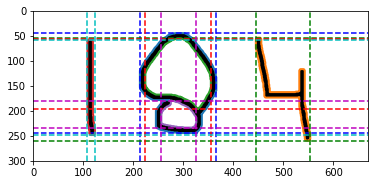

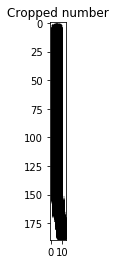

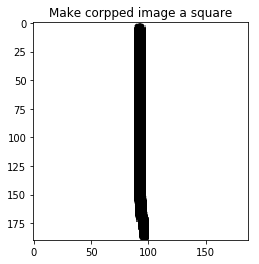

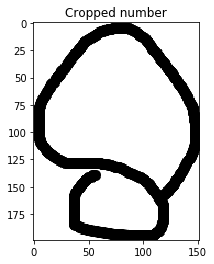

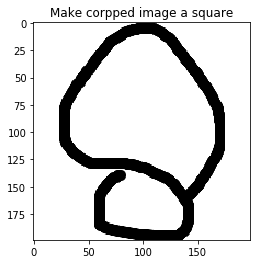

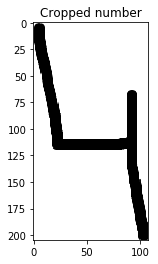

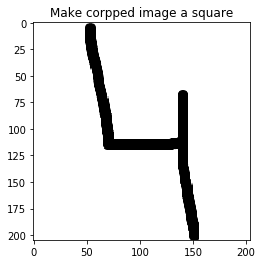

0 contours dropped


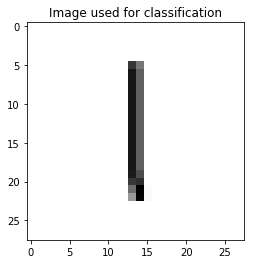

Classified: 1


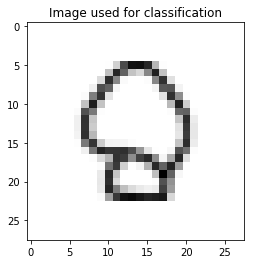

Classified: 8


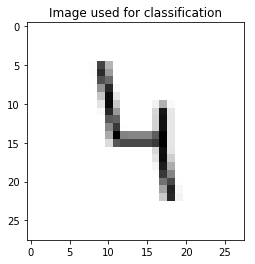

Classified: 4


In [86]:
c.classify()